In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from numba import njit
from numpy.random import normal

In [96]:
@njit
def euler_Method(S0, interest_rate, delta_t, N, volatility):
    prev_S = S0
    stock_prices = np.empty(N)
    stock_prices[0] = S0
    for i in range(1, N):  # Use prange for parallel execution
        Zm = normal()
        next_S = prev_S * (1 + interest_rate * delta_t + volatility * np.sqrt(delta_t) * Zm)
        prev_S = next_S
        stock_prices[i] = next_S
    return stock_prices

In [97]:
def confidence_interval(data):
        """
        Function to calculate confidence interval

        Args:
            data: Data for which confidence interval is to be calculated

        Returns:
                m-h, m+h : Lower and upper bounds of the confidence interval
        """
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m - h, m + h

In [98]:
@njit
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type, seed = 0):
    """
    Function to price the option using Monte Carlo simulation  
    Args:
        S0 : Initial stock price
        r : Risk-free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatility of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option ('call' or 'put')
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    
    # Calculate price option and standard error
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
  
    m, sd = np.mean(pay_offs * np.exp(-r*T)), np.std(pay_offs * np.exp(-r*T))
    h = 1.96 * sd / np.sqrt(M) # Confidence interval calculation
    ml, mu = m - h, m + h # Lower and upper bounds
    
    return price_option, std_error, ml, mu

In [99]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatility):
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatility**2/2) * tao)/(volatility*np.sqrt(tao))
    d2 = d1 - volatility * np.sqrt(tao)
    option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
    
    return option_price

In [100]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
# Option price from black scholes
option_BS = blackScholes(S0, K, 0, T, r, sigma)

In [101]:
m = np.arange(100, 10000, 100)
option_values = []
std_errors = []
lower = []
upper = []
# Monte Carlo Simulation for option pricing
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values.append(option_value)
    std_errors.append(sd_error)
    lower.append(ml)
    upper.append(mu)
print(option_values[-1])

100%|██████████| 99/99 [00:01<00:00, 50.21it/s]

4.807496514790537


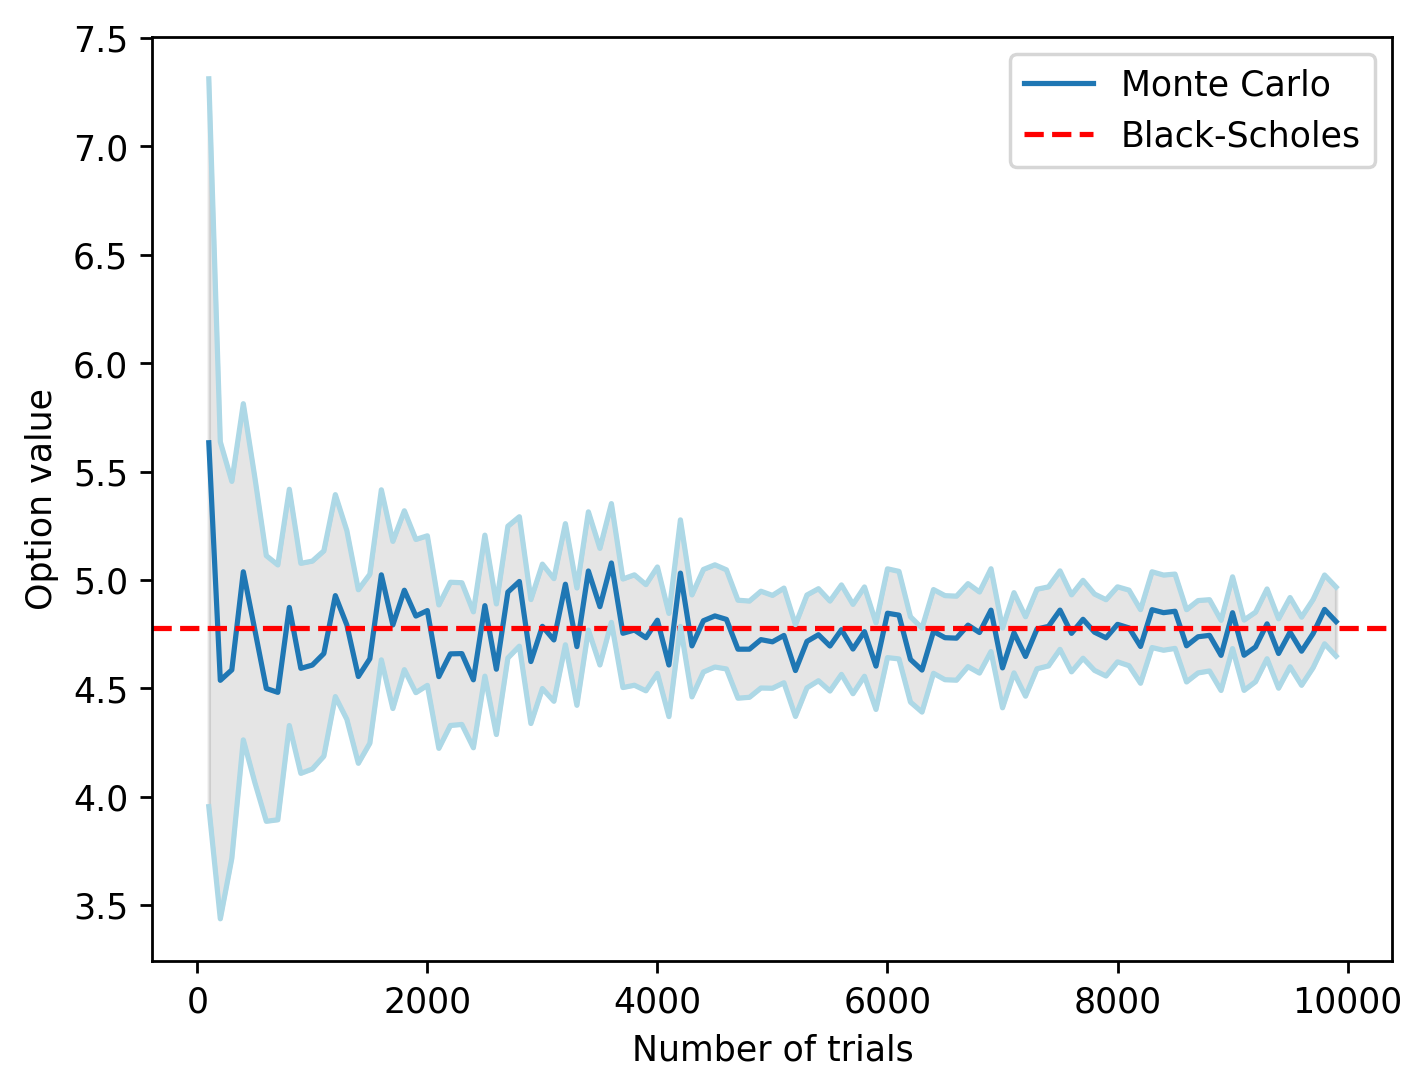

In [102]:
plt.figure(dpi=250)
plt.plot(m, option_values, label='Monte Carlo')
plt.axhline(option_BS, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper,color = "lightblue")
plt.plot(m, lower, color = "lightblue")
plt.fill_between(m, upper, lower, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()
print()

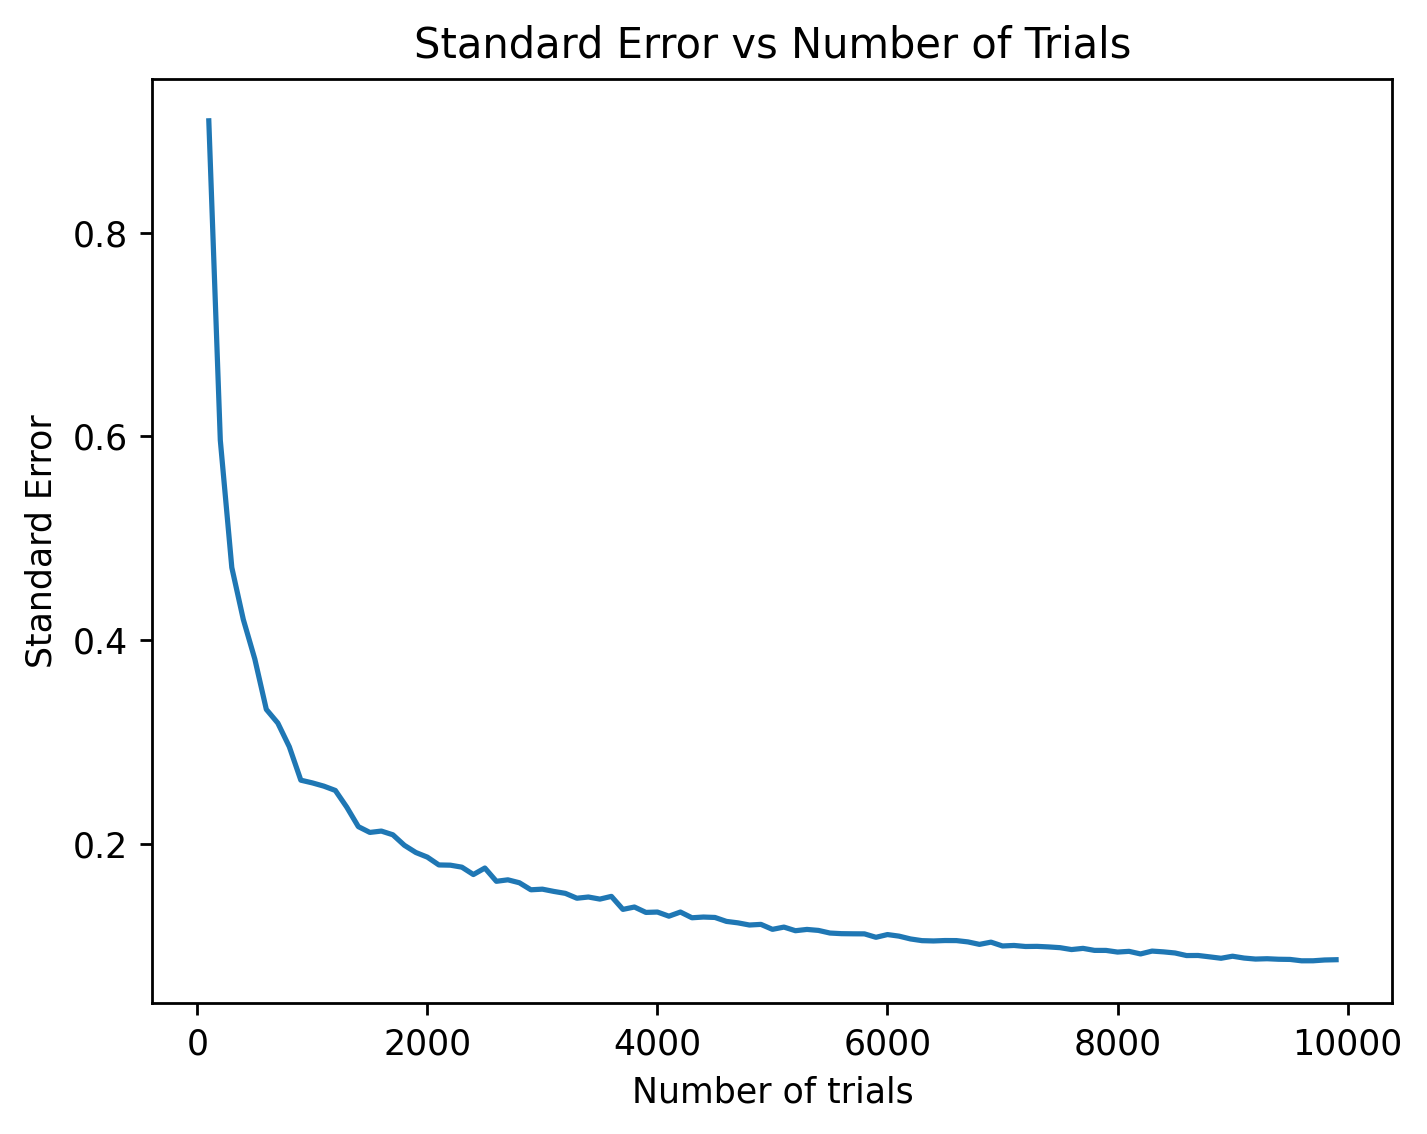

In [103]:
plt.figure(dpi=250)
plt.plot(m, std_errors)
plt.xlabel("Number of trials")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Number of Trials")
plt.show()

In [104]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
delta_t = 1/252
N = int(T/delta_t)
m = np.arange(100, 10000, 100)
# Monte Carlo Simulation for option pricing for volatility = 0.5
sigma = 0.5
option_values2= []
std_errors2 = []
lower2 = []
upper2 = []
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values2.append(option_value)
    std_errors2.append(sd_error)
    lower2.append(ml)
    upper2.append(mu)

100%|██████████| 99/99 [00:01<00:00, 64.04it/s] 


In [105]:
# Option price from black scholes for volatility = 0.5
option_BS2 = blackScholes(S0, K, 0, T, r, sigma)

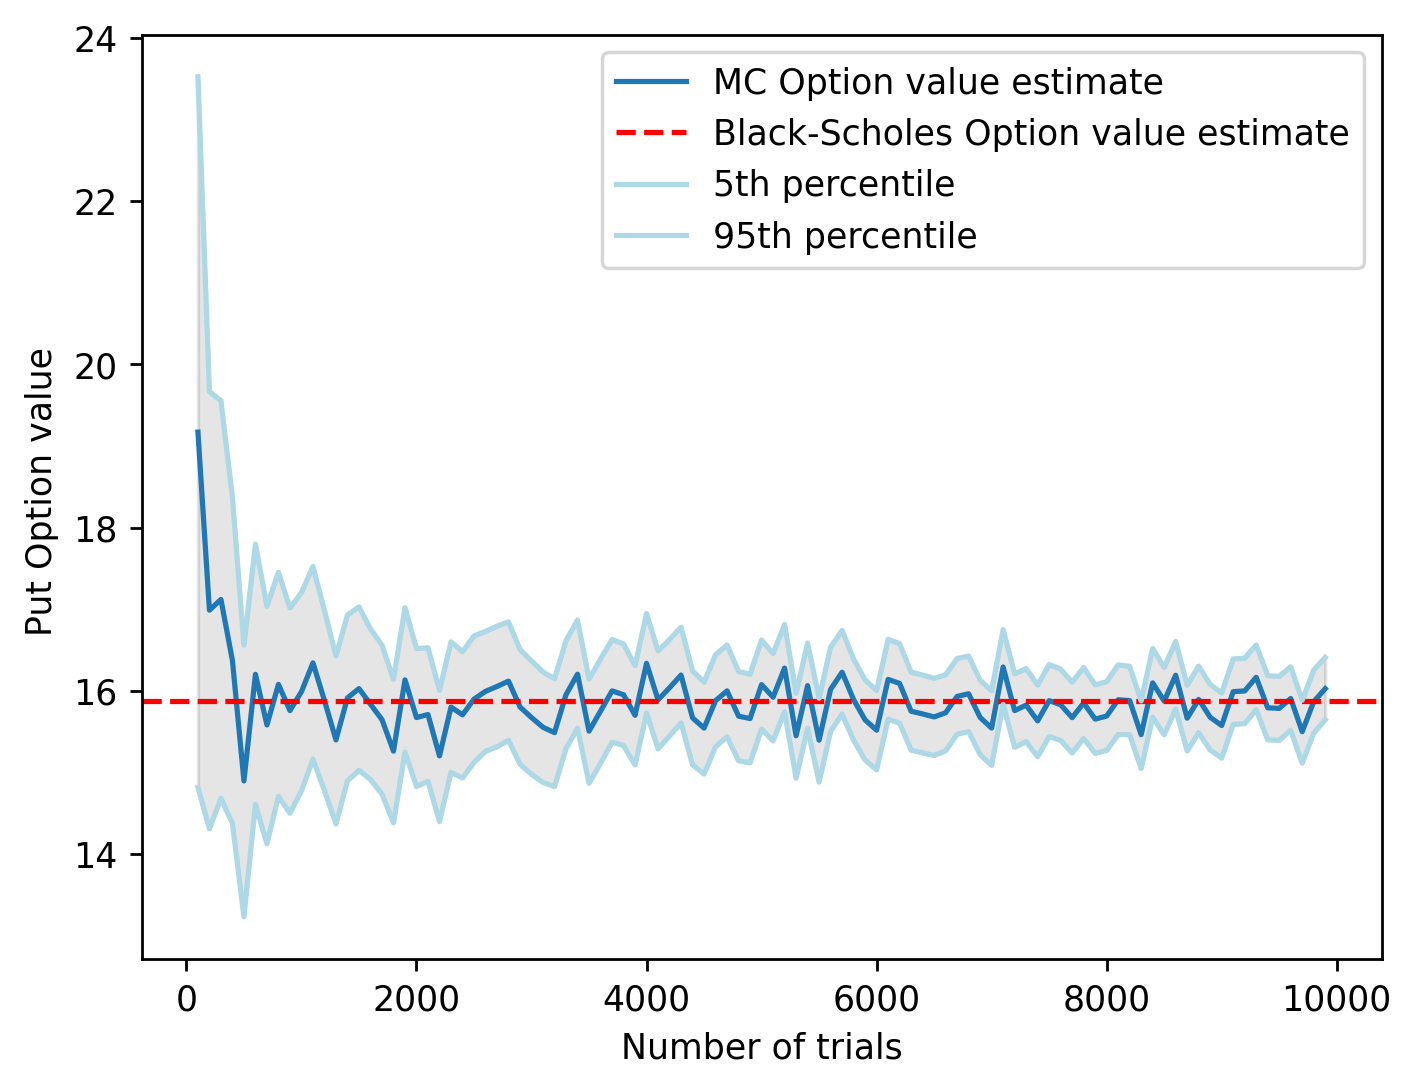

In [106]:
# Plot for option pricing for volatility = 0.5 using Monte Carlo
plt.figure(dpi=250)
plt.plot(m, option_values2, label='MC Option value estimate')
plt.axhline(option_BS2, linestyle = "--", color = "red", label="Black-Scholes Option value estimate")
plt.plot(m, upper2, color = "lightblue", label = '5th percentile')
plt.plot(m, lower2, color = "lightblue", label = '95th percentile')
plt.fill_between(m, upper2, lower2, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel(" Put Option value")
plt.legend()
plt.show()

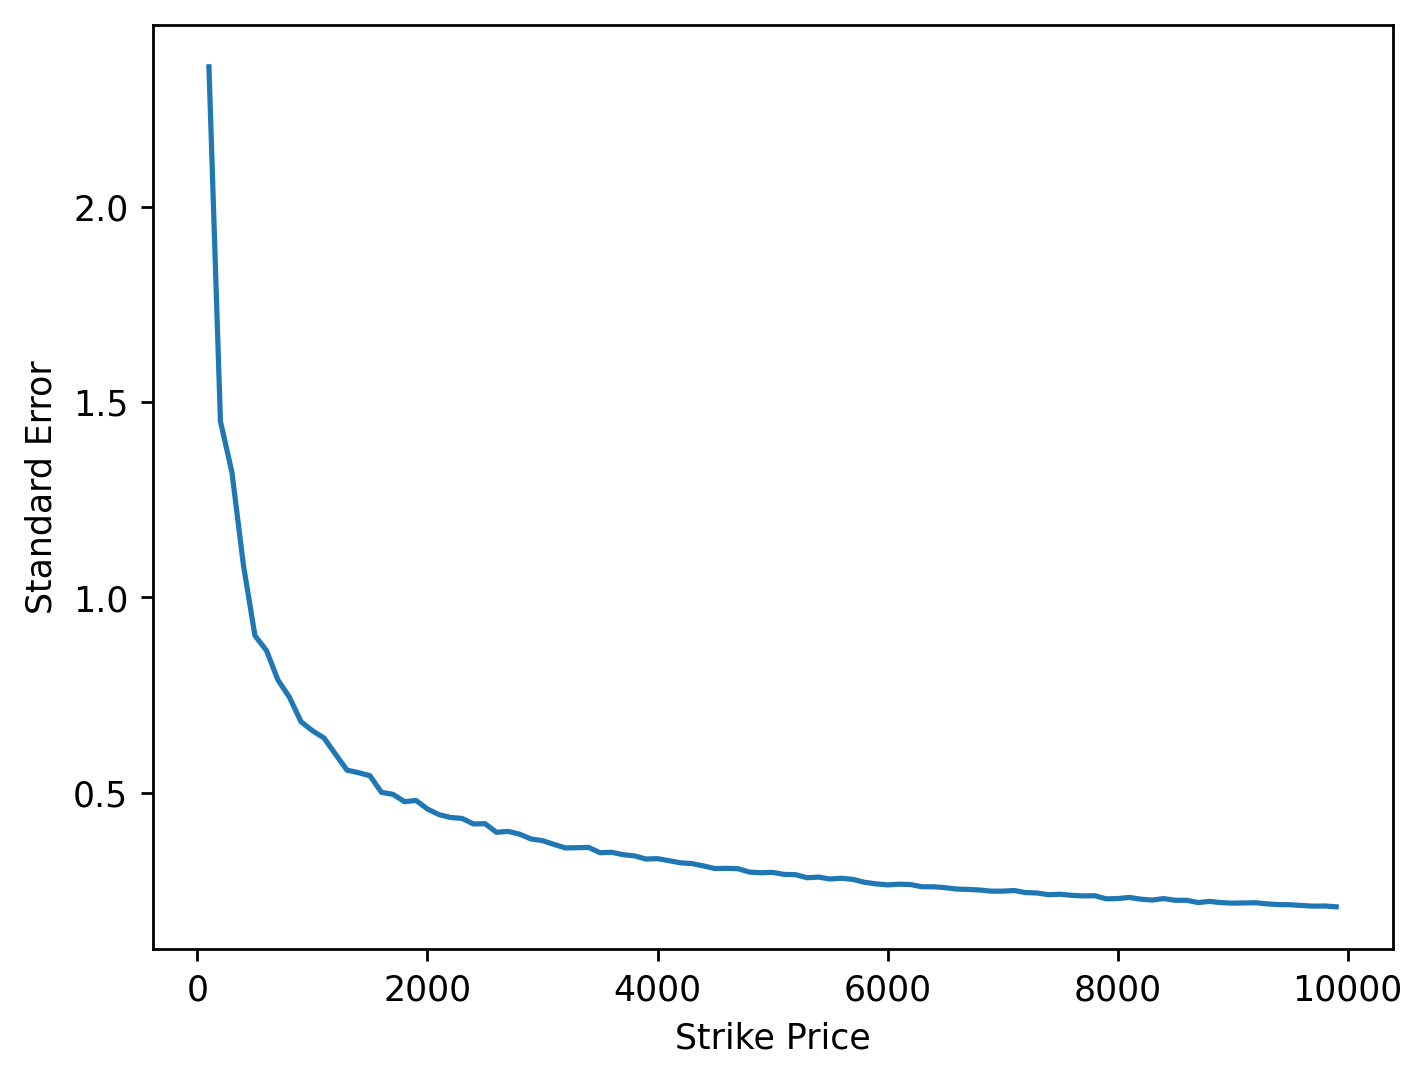

In [107]:
# Plot for standard error for volatility = 0.5 using Monte Carlo
plt.figure(dpi=250)
plt.plot(m, std_errors2)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.show()

##### Varying strike Price

In [108]:
# Parameters
K = np.arange(80, 120, 2)
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 5000
N = int(T/delta_t)


option_values3 = []
std_errors3 = []
lower3 = []
upper3 = []

for k in tqdm(K):
    option_value, sd_error , ml, mu  = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    option_values3.append(option_value)
    std_errors3.append(sd_error)
    lower3.append(ml)
    upper3.append(mu)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 30.91it/s]


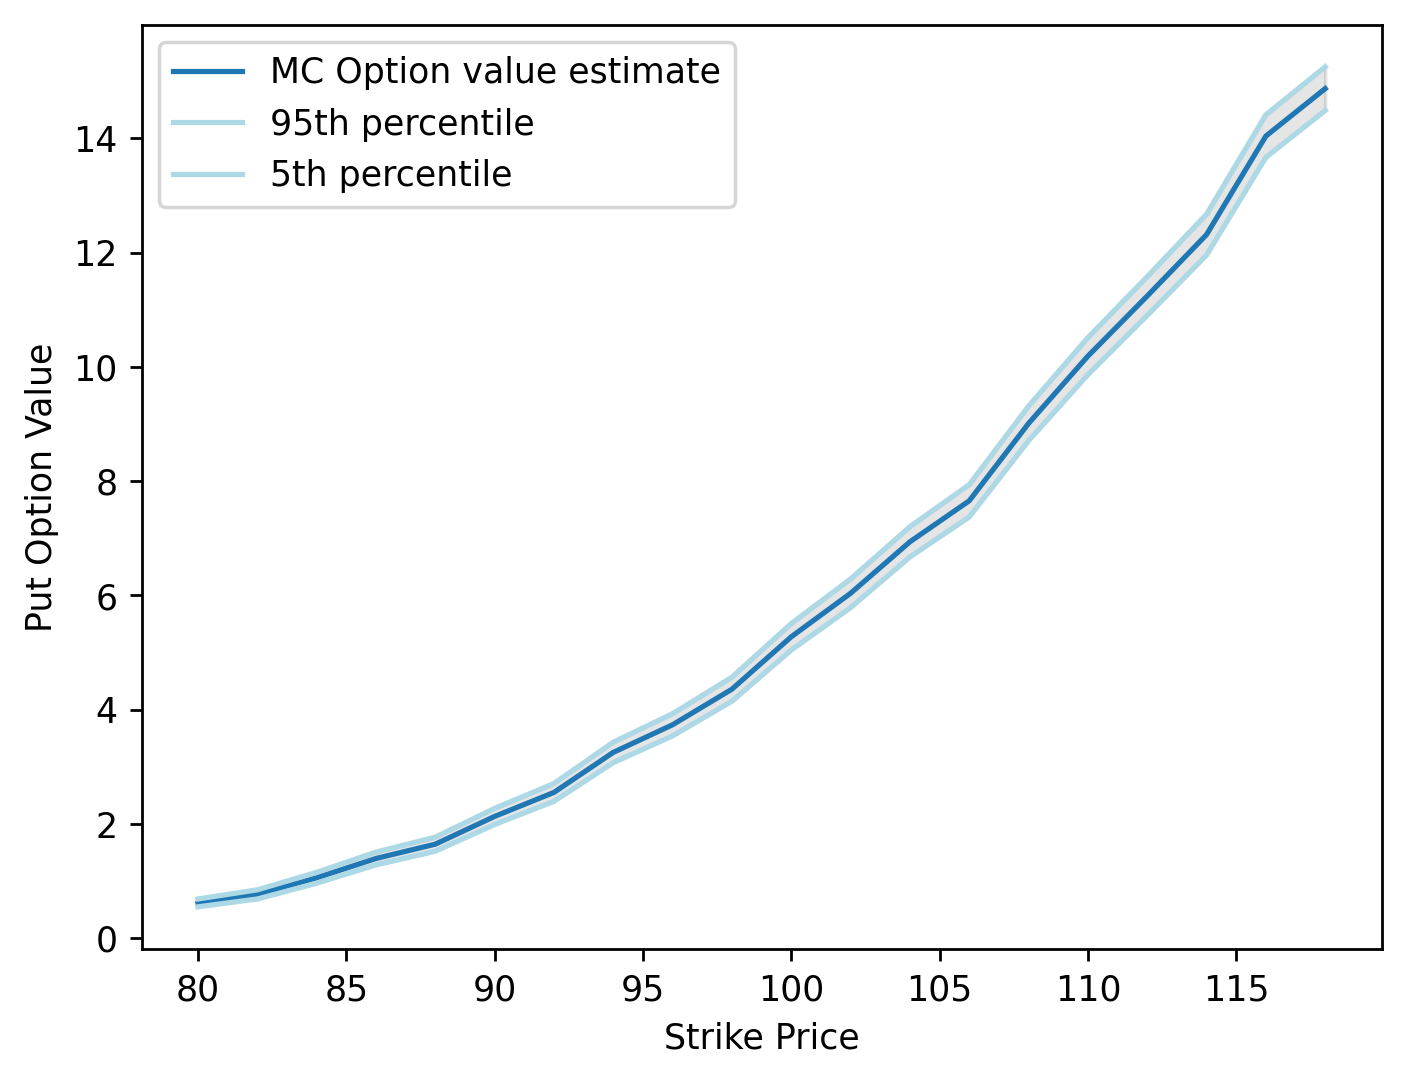

In [109]:
##Plotting the option values
plt.figure(dpi=250)
plt.plot(K, option_values3, label = 'MC Option value estimate')

plt.plot(K, upper3, color = "lightblue", label = '95th percentile')
plt.plot(K, lower3, color = "lightblue", label = '5th percentile')
plt.xlabel("Strike Price")
plt.ylabel("Put Option Value")
plt.fill_between(K, upper3, lower3, color="k", alpha=0.1)
plt.legend()

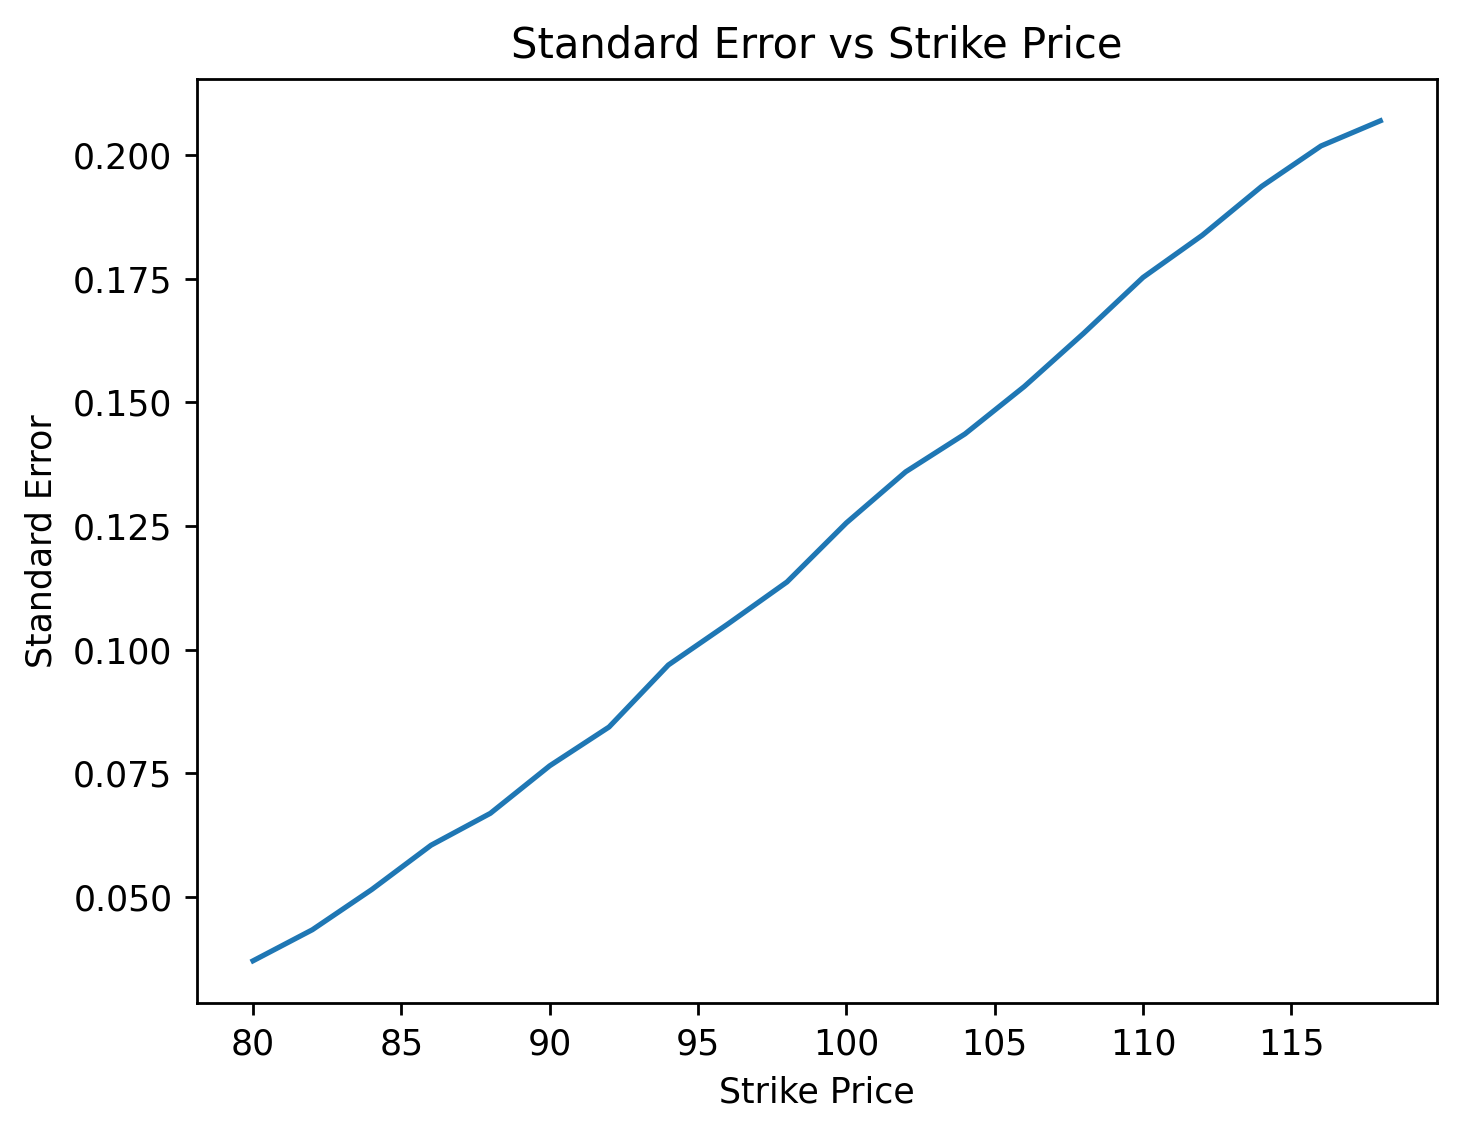

In [110]:
plt.figure(dpi=250)
plt.plot(K, std_errors3)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Strike Price")
plt.show()

### Varying volatility in Monte Carlo 

In [111]:
# Parameters
vols = np.arange(0.1, 0.5, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 5000
N = int(T/delta_t)
option_values = []
CI_lower =[]
CI_upper =[]
for vol in vols:
    option_value, _, CI_lowerbound, CI_upperbound = priceOption(S0, r, delta_t, N, vol, K, M, "call")
    # m.append(M)
    option_values.append(option_value)
    CI_lower.append(CI_lowerbound)
    CI_upper.append( CI_upperbound)

In [112]:
np.array(option_values).shape

(40,)

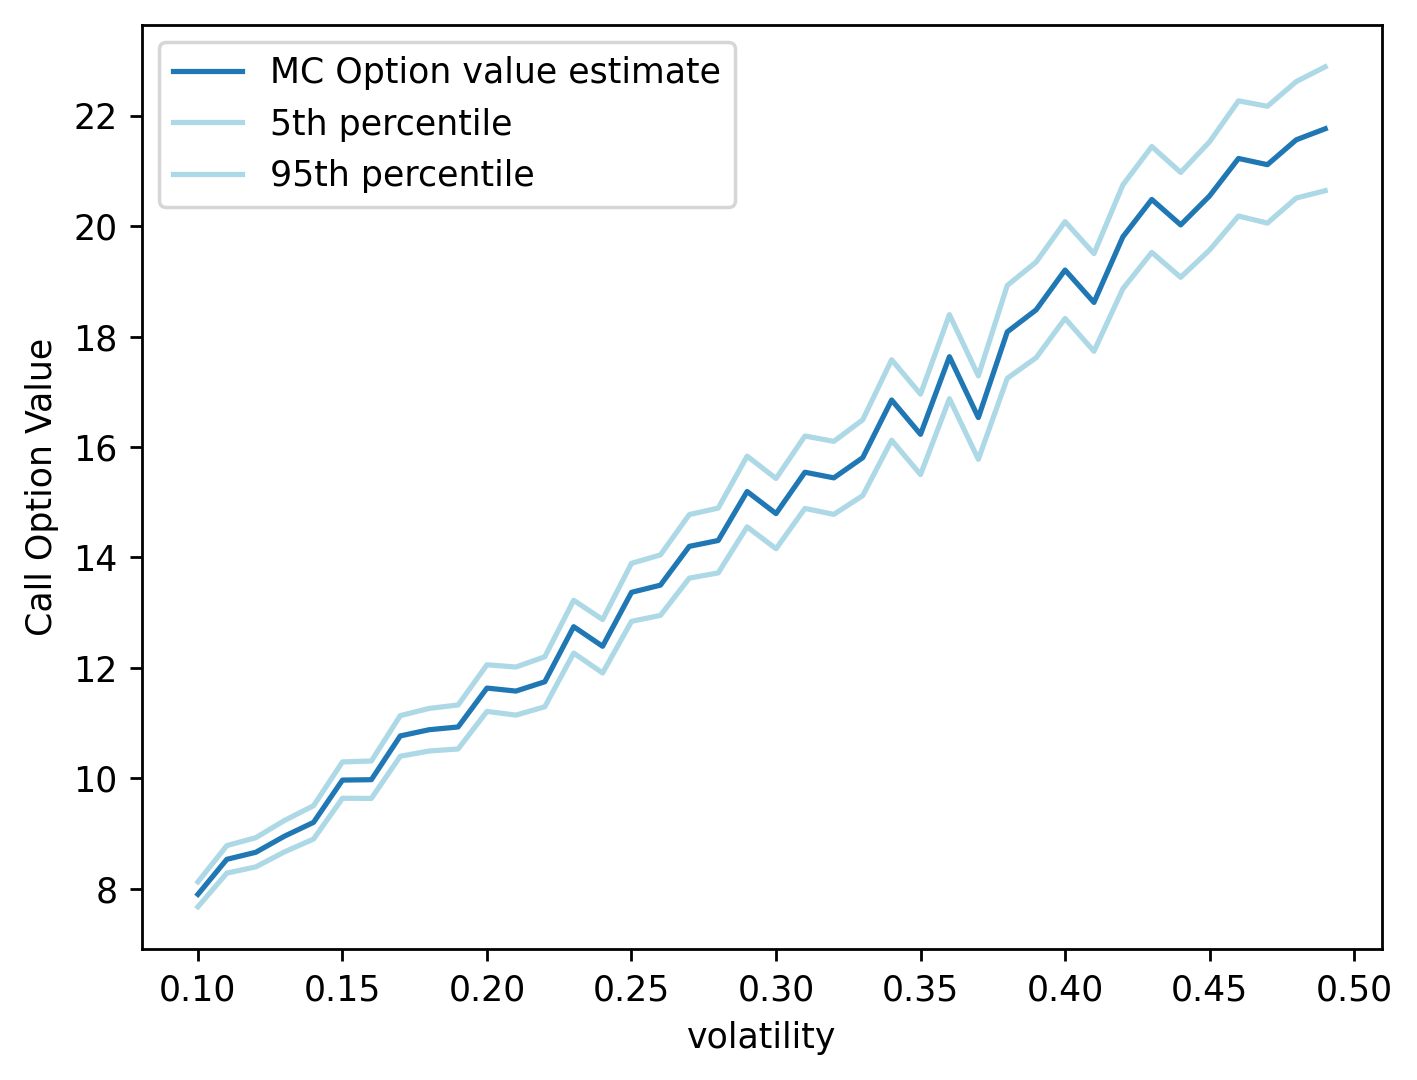

In [113]:
##Plotting the option values
plt.figure(dpi=250)
plt.plot(vols, option_values, label = 'MC Option value estimate')
plt.plot(vols, CI_lower, color = "lightblue", label = '5th percentile')
plt.plot(vols, CI_upper, color = "lightblue", label = '95th percentile')
plt.xlabel("volatility")
plt.ylabel("Call Option Value")
plt.legend()

### Part I - B

##### Milstein - Heston Model

In [114]:

## Milstein Variance Process
@njit
def m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, Barrier, K):
    prev_v = 0
    prev_S = S0
    Zv = np.random.normal()
    Z2 = np.random.normal()
    Zs = corr * Zv + np.sqrt(1 - corr ** 2) * Z2  
    
    for _ in np.arange(dt, 1., dt):
        vplus = max(0, prev_v)
        next_v = prev_v + k * (theta - vplus) * dt + vol_of_vol * np.sqrt(vplus * dt) * Zv + (vol_of_vol ** 2 * dt * (Zv ** 2 - 1)) / 4
        next_S = prev_S + r * prev_S * dt + np.sqrt(vplus * dt) * Zs * prev_S + (vplus * prev_S * dt * (Zs ** 2 - 1)) / 2
        prev_v = next_v
        prev_S = next_S
        if next_S >= Barrier:
            return 0
    
    payOff = max(0, next_S - K)
    return payOff
        

In [115]:
@njit
def approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K, T):
    payoffs_MH = np.zeros(10000)
    for i in range(10000):
        payoff = m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, B, K)
        payoffs_MH[i] = payoff
    option_approx = np.mean(payoffs_MH) * np.exp(-r * T)
    return option_approx

## Analysis

In [116]:
#### Initial Parameters
r = 0.05
theta = 0.04
k = 2
vol_of_vol = 0.1
corr = - 0.7
dt = 1/252
S0 =100
T = 1.0
K = 100
Barrier = np.arange(90, 120, 0.5)

#### Variation in Barrier

In [117]:
## Approximating the option price using Milstein Variance Process with Varying Barrier
option_prices_B = []
for B in tqdm(Barrier):
    option_approx = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K, T)
    option_prices_B.append(option_approx)   

100%|██████████| 60/60 [00:00<00:00, 67.16it/s]


Text(0, 0.5, 'Option Value')

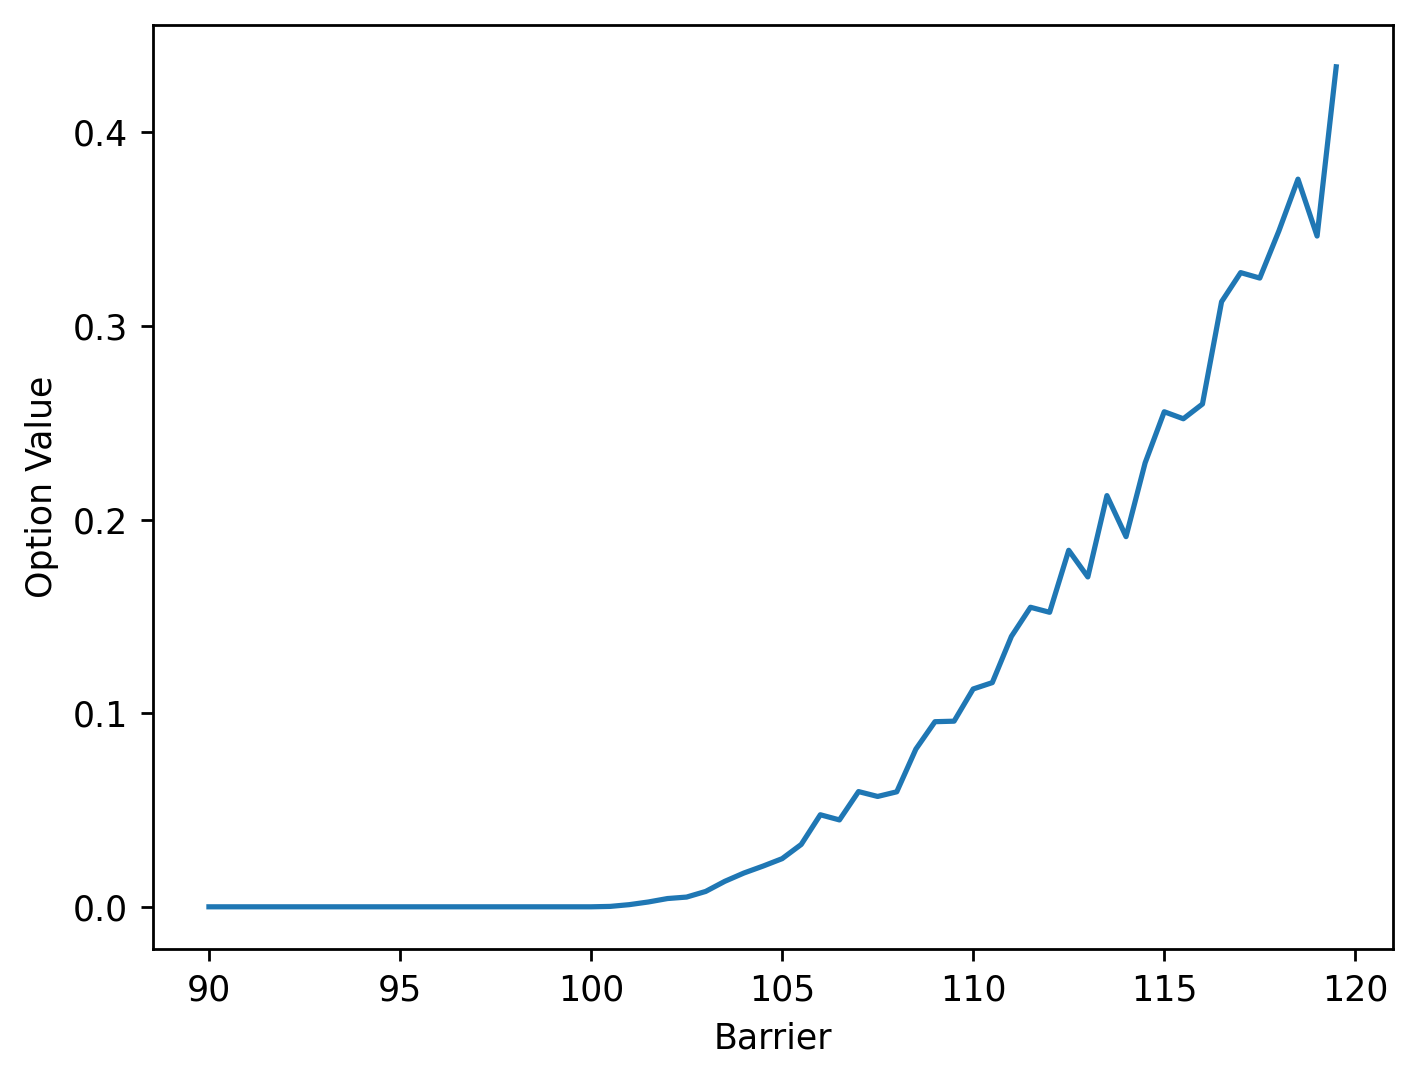

In [118]:
# Plotting the option prices for different barriers with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(Barrier, option_prices_B)
plt.xlabel("Barrier")
plt.ylabel("Option Value")


#### Variation in Correlation

In [119]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
vol_of_vol = 0.1    # volatility of volatility
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120            # barrier         
#Correlation
corr = np.arange(-1, 1.1, 0.1)

In [120]:
option_prices_corr = []
for Correlation in tqdm(corr):
    option_approx = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, Correlation, r, S0, B, K, T)
    option_prices_corr.append(option_approx)

100%|██████████| 21/21 [00:00<00:00, 34.29it/s]


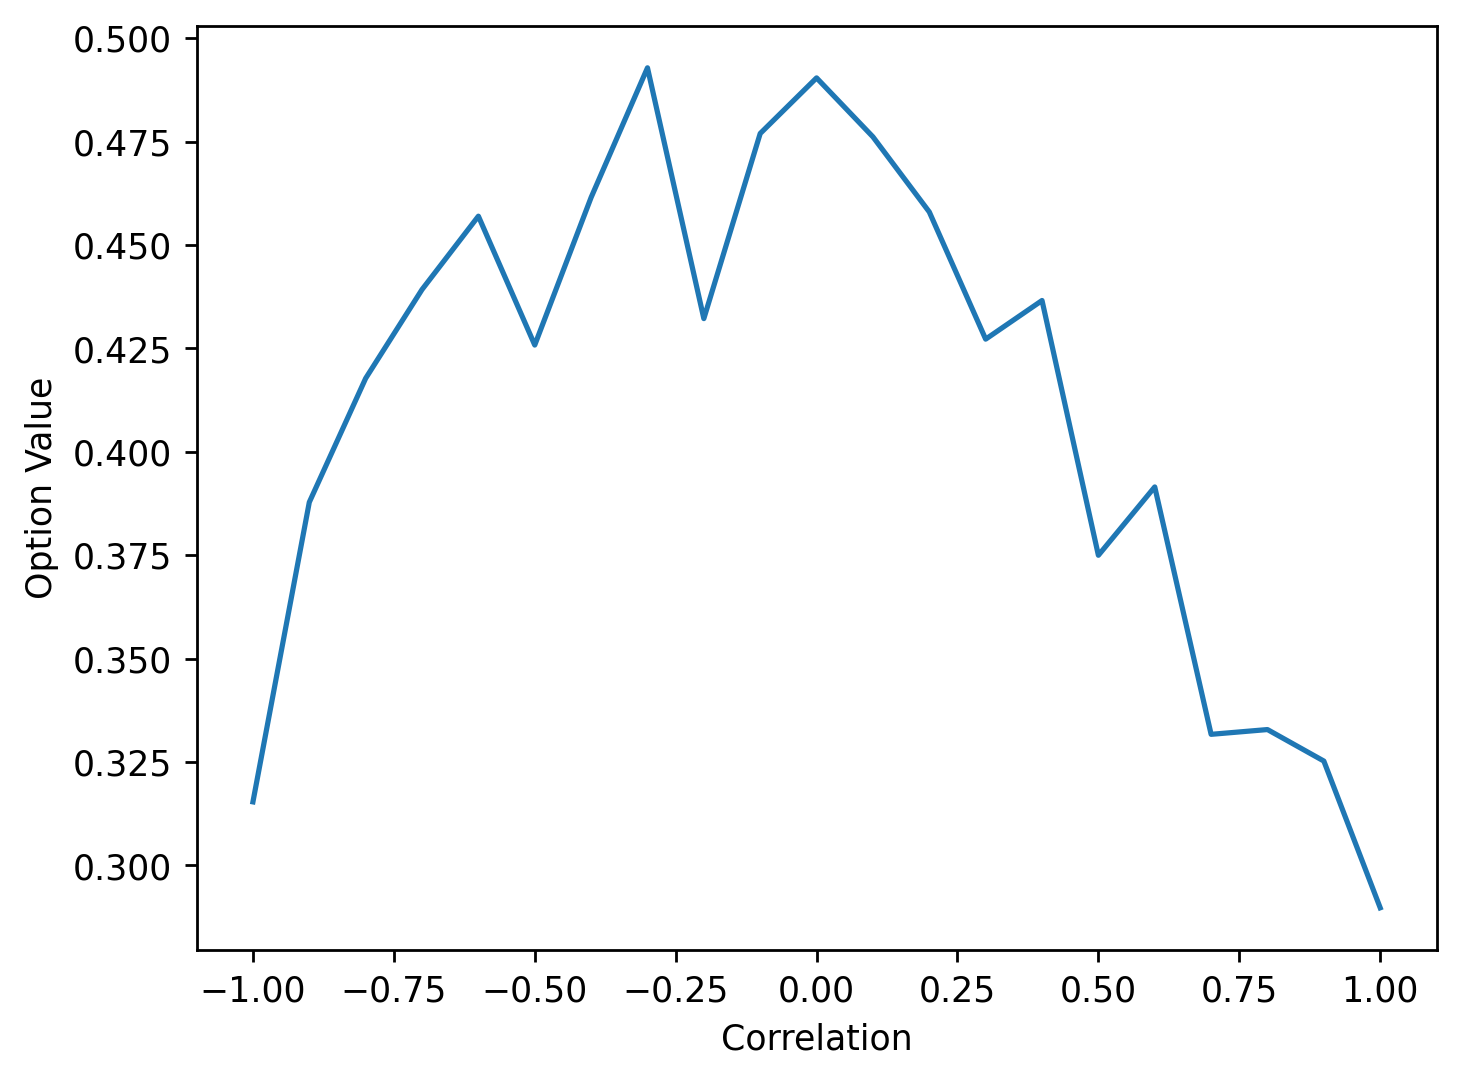

In [121]:
# Plotting the option prices for different correlation with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(corr, option_prices_corr)
plt.xlabel("Correlation")
plt.ylabel("Option Value")
plt.show()

#### Variation in Vol of Vol

In [122]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120            # barrier         
#Correlation
vol_of_vol = np.arange(0, 1, 0.025)

In [123]:
# Approximating the option price using Milstein Variance Process with Varying Volatility of Volatility
option_prices_vol_of_vol = []
for volOfvol in tqdm(vol_of_vol):
    option_approx = approximateOptionPrice_MH(k, dt, volOfvol, theta, corr, r, S0, B, K, T)
    option_prices_vol_of_vol.append(option_approx)

100%|██████████| 40/40 [00:00<00:00, 52.22it/s]


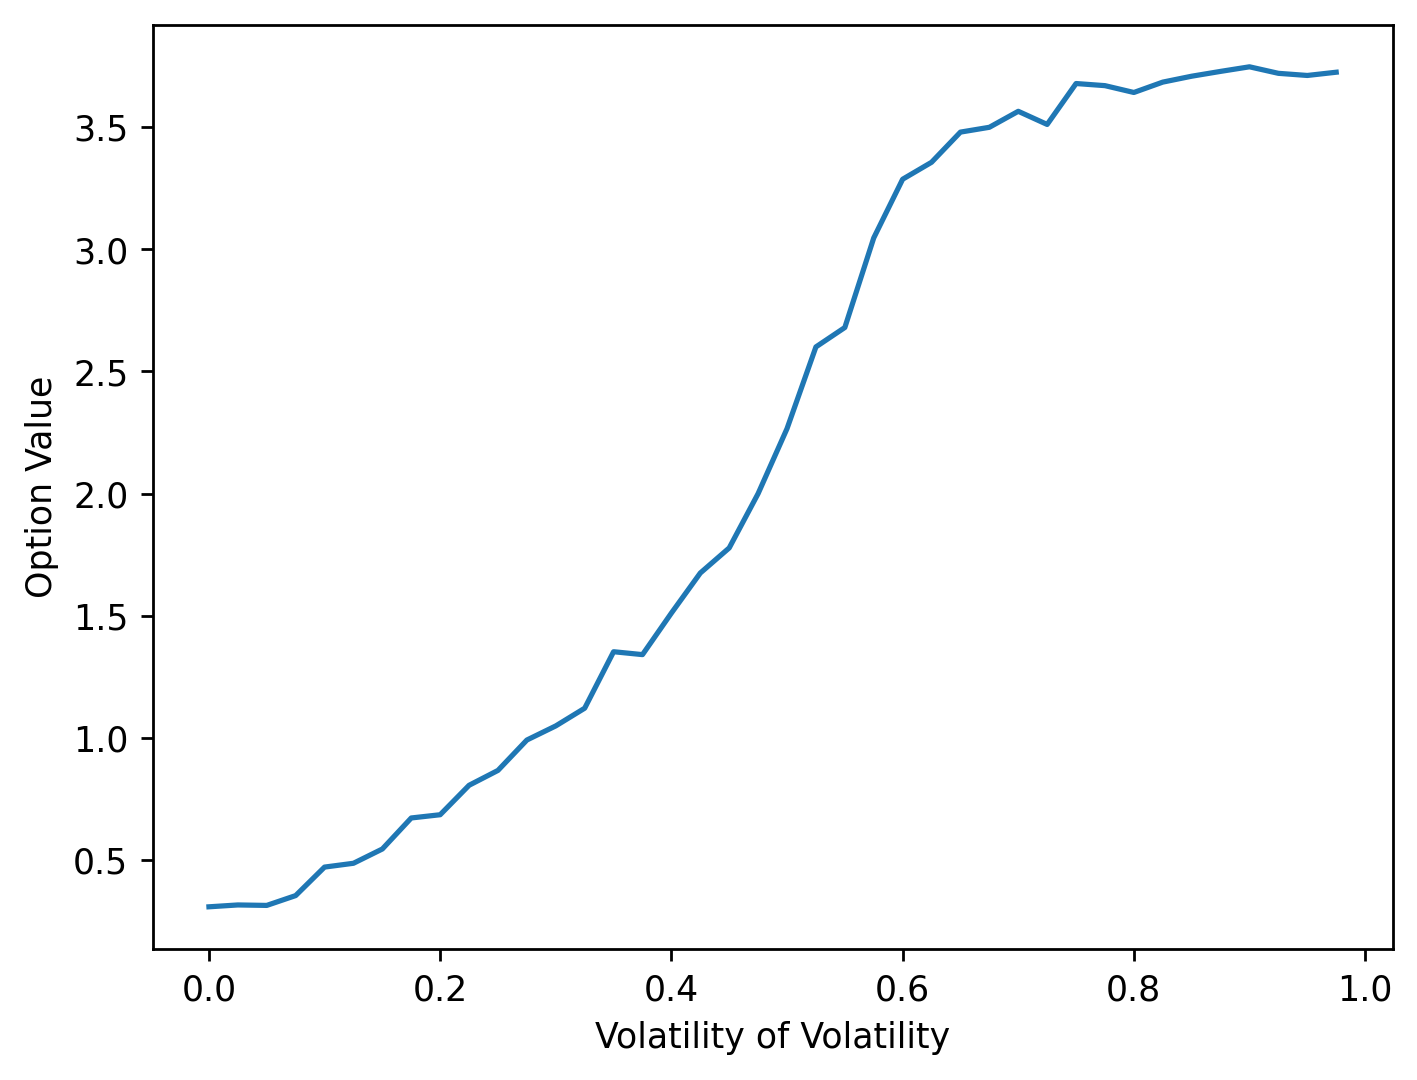

In [124]:
# Plotting the option prices for different volatility of volatility with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(vol_of_vol, option_prices_vol_of_vol)
plt.xlabel("Volatility of Volatility")
plt.ylabel("Option Value")
plt.show()

##### Variation in Mean Reversion

In [125]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
vol_of_vol = 0.1      # volatility of volatility
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
# Mean Reversion
k = np.arange(0, 10, 0.05)

In [126]:
# Approximating the option price using Milstein Variance Process with Varying Mean Reversion
option_prices_k = []
for k_ in tqdm(k):
    option_approx = approximateOptionPrice_MH(k_, dt, vol_of_vol, theta, corr, r, S0, B, K, T)
    option_prices_k.append(option_approx)

100%|██████████| 200/200 [00:03<00:00, 55.66it/s]


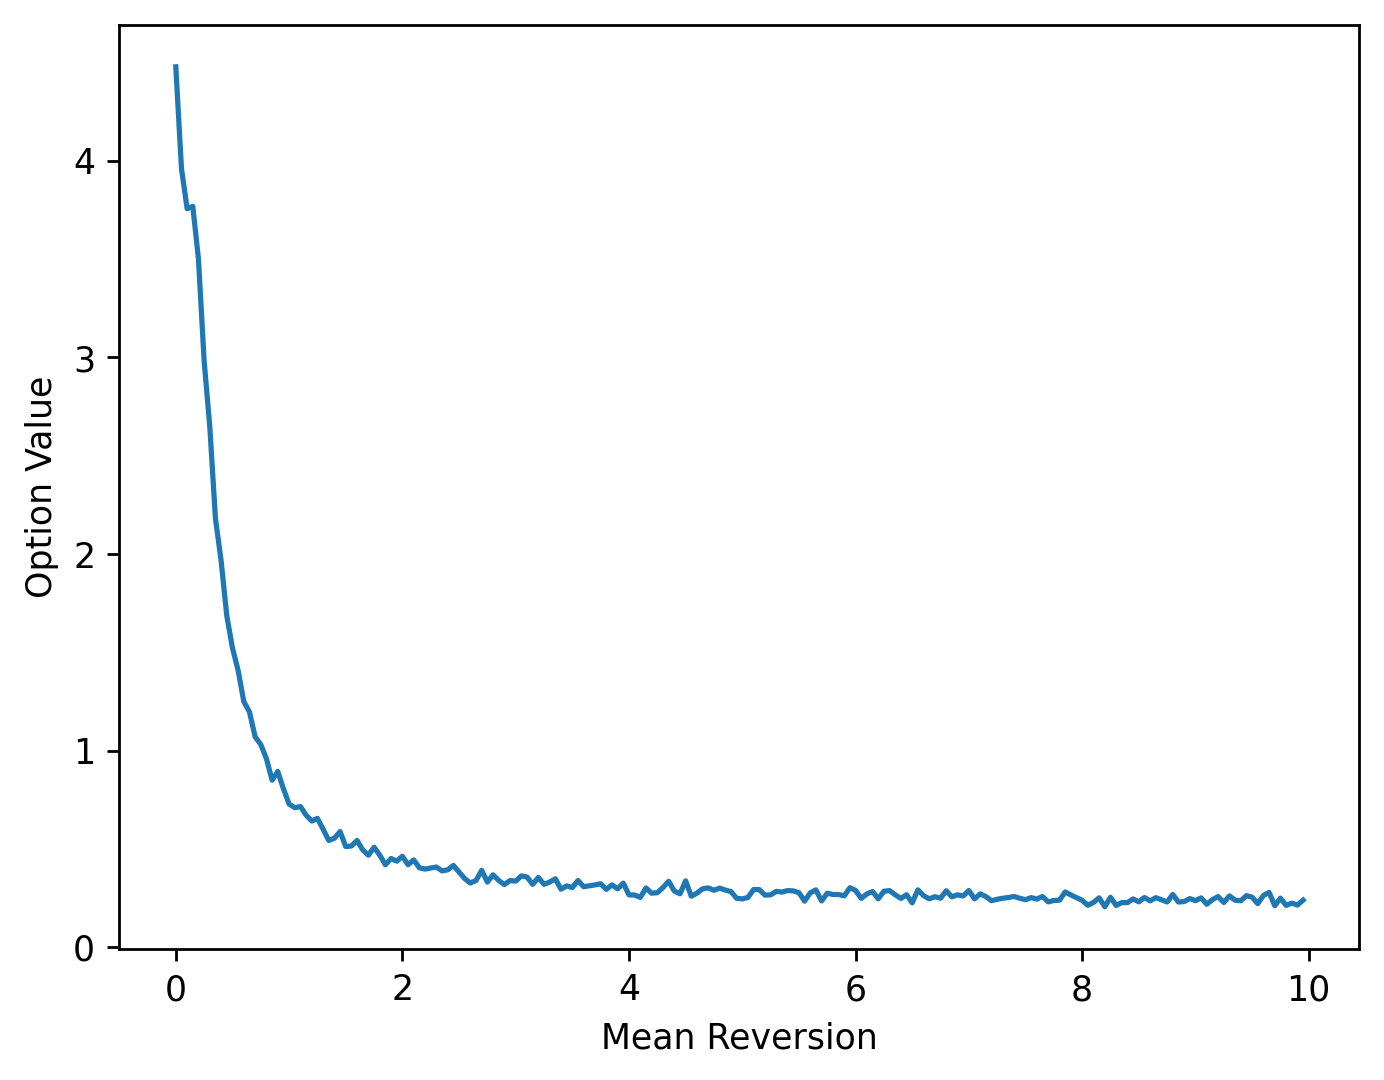

In [127]:
# Plotting the option prices for different mean reversion with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(k, option_prices_k)
plt.xlabel("Mean Reversion")
plt.ylabel("Option Value")
plt.show()

# Part 2: Black Scholes

### Helper fuctions

In [128]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatility):
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatility**2/2) * tao)/(volatility*np.sqrt(tao))
    d2 = d1 - volatility * np.sqrt(tao)
    option_price = current_stock_price * norm.cdf(d1) - np.exp(-interest_rate * tao) * strike_price * norm.cdf(d2)
    
    return option_price, norm.cdf(d1)

In [129]:
def calc_delta_bump(option_price_array, bumped_option_price_array, bump_size):
    option_price_array = np.array(option_price_array)
    bumped_option_price_array = np.array(bumped_option_price_array)
    delta_est = (option_price_array - bumped_option_price_array)/bump_size
    return delta_est


In [130]:
def logistic_smoothing(value, epsilon):
    return 

In [131]:
@njit
def digital_option_payoff(S0, K, type='call', position='long', smooth='no', epsilon=0.001):
    if smooth == 'no':
        if type == 'call':
            payoff = np.maximum(0, S0 - K)
        elif type == 'put':
            payoff = np.maximum(0, K - S0)
    elif smooth == 'yes':
        if type == 'call':
            payoff = 1 / (1 + np.exp(-1 * np.maximum(0, S0 - K) / epsilon))
        elif type == 'put':
            payoff = 1 / (1 + np.exp(-1 * np.maximum(0, K - S0) / epsilon))

    if position == 'long':
        return payoff
    elif position == 'short':
        return -1 * payoff

    

In [132]:
K = np.arange(80, 90,2)
T = 1.0
r = 0.06
S0 = 100 
K = 99
sigma = 0.2
delta_t = 0.001
M = 9000
N = int(T/delta_t)
bump = 0.5


option_value, _, _, _ = priceOption(S0, r, delta_t, N, sigma, K, M, "call")
option_bumped, _, _, _  = priceOption(S0 + bump, r, delta_t, N, sigma, K, M, "call")
delta_bump = (np.array(option_bumped) - np.array(option_value))/bump
BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatility=sigma)[1]


print(f"Monte Carlo Delta: {delta_bump}")
print(f"Black-Scholes Delta: {BS_delta}")



Monte Carlo Delta: 0.8334676408986397
Black-Scholes Delta: 0.6737355117348961


## Plotting delta's

<Figure size 1600x1200 with 0 Axes>

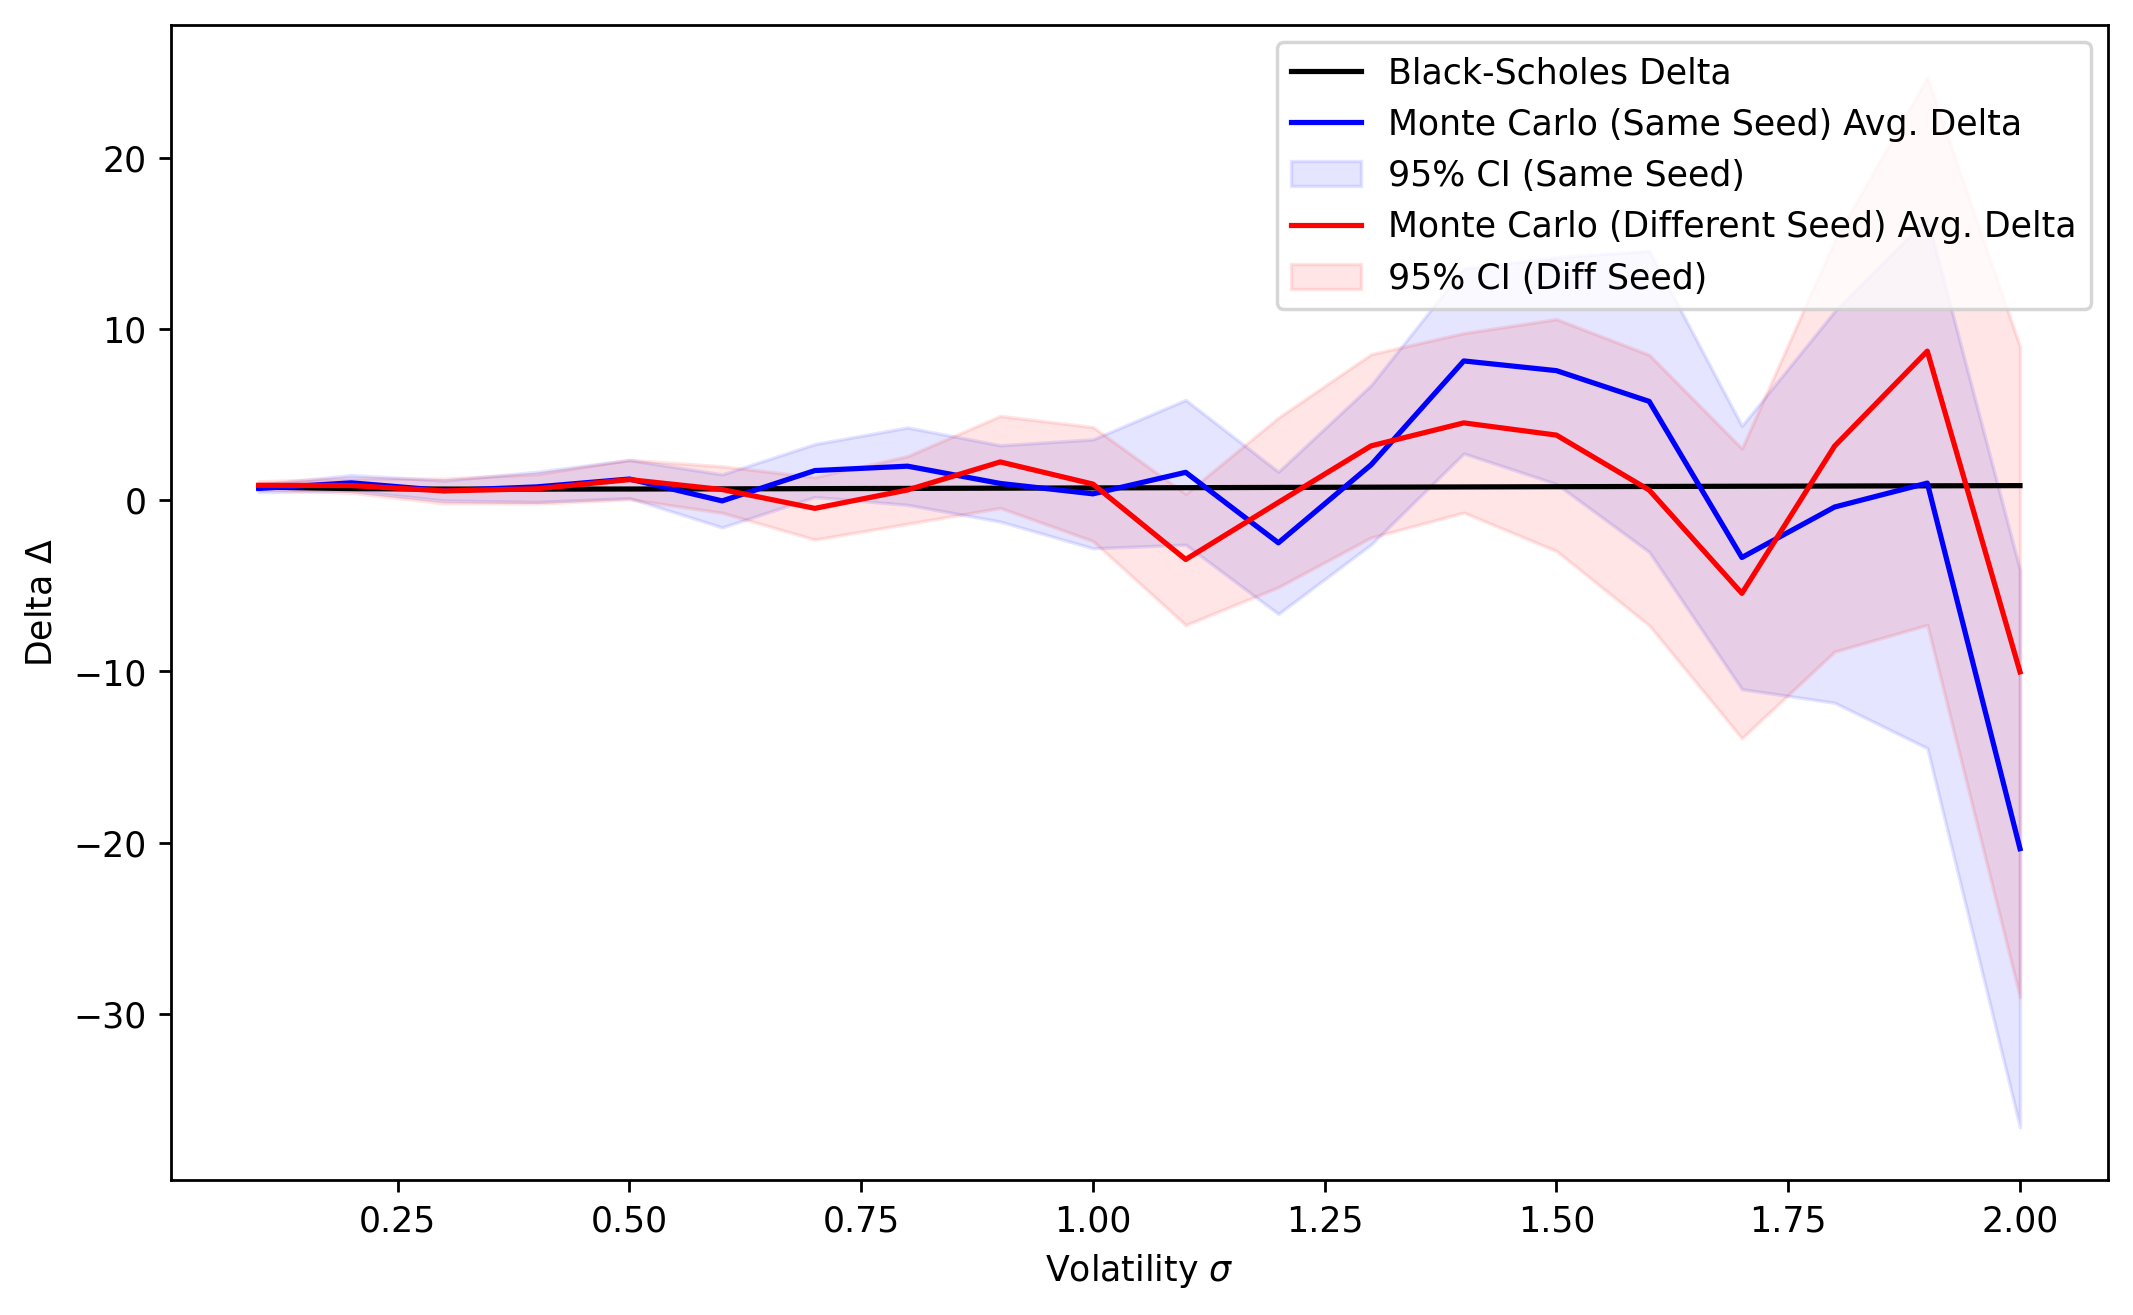

In [133]:
# Given parameters
N = 50
K = 99
r = 0.06
S0 = 100
T = 1
M = 100
runs = 100
delta_t = T / N  
bump = 1

volatilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2])
delta_array_same_seed = np.zeros((len(volatilities), runs))  # Store deltas for same seed
delta_array_diff_seed = np.zeros((len(volatilities), runs))  # Store deltas for different seed


plt.figure(dpi=250)
for index in range(runs):
    deltas_same_seed = []
    deltas_diff_seed = []

    for σ in volatilities:
        seed = np.random.seed(42)
        option_value = priceOption(S0, r, delta_t, N, σ, K, M, "call", seed)[0]
        option_bumped_same_seed = priceOption(S0 + bump, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        seed = np.random.seed()  
        option_bumped_diff_seed = priceOption(S0 + bump, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        delta_MC_same_seed = (option_bumped_same_seed - option_value) / bump
        delta_MC_diff_seed = (option_bumped_diff_seed - option_value) / bump
        
        deltas_same_seed.append(delta_MC_same_seed)
        deltas_diff_seed.append(delta_MC_diff_seed)

    delta_array_same_seed[:, index] = deltas_same_seed
    delta_array_diff_seed[:, index] = deltas_diff_seed

# Calculate average delta for both methods
avg_delta_same_seed = np.mean(delta_array_same_seed, axis=1)
avg_delta_diff_seed = np.mean(delta_array_diff_seed, axis=1)

# Calculate standard deviations
std_delta_same_seed = np.std(delta_array_same_seed, axis=1)
std_delta_diff_seed = np.std(delta_array_diff_seed, axis=1)

# Calculate 95% confidence intervals
confidence_interval_same_seed = 1.96 * (std_delta_same_seed / np.sqrt(runs))
confidence_interval_diff_seed = 1.96 * (std_delta_diff_seed / np.sqrt(runs))

# Plotting corrections
plt.figure(figsize=(10, 6), dpi=250)
BS_deltas = [blackScholes(S0, K, 0, T, r, σ)[1] for σ in volatilities]
plt.plot(volatilities, BS_deltas, label='Black-Scholes Delta', color='black')
plt.plot(volatilities, avg_delta_same_seed, label='Monte Carlo (Same Seed) Avg. Delta', color='blue')
plt.fill_between(volatilities, avg_delta_same_seed - confidence_interval_same_seed, avg_delta_same_seed + confidence_interval_same_seed, color='blue', alpha=0.1, label='95% CI (Same Seed)')
plt.plot(volatilities, avg_delta_diff_seed, label='Monte Carlo (Different Seed) Avg. Delta', color='red')
plt.fill_between(volatilities, avg_delta_diff_seed - confidence_interval_diff_seed, avg_delta_diff_seed + confidence_interval_diff_seed, color='red', alpha=0.1, label='95% CI (Diff Seed)')

plt.xlabel('Volatility $\sigma$')
plt.ylabel('Delta $\Delta$')
plt.legend()
plt.show()

Hedge param delta error MC vs. Black-Scholes using Bump and revalue, same seed

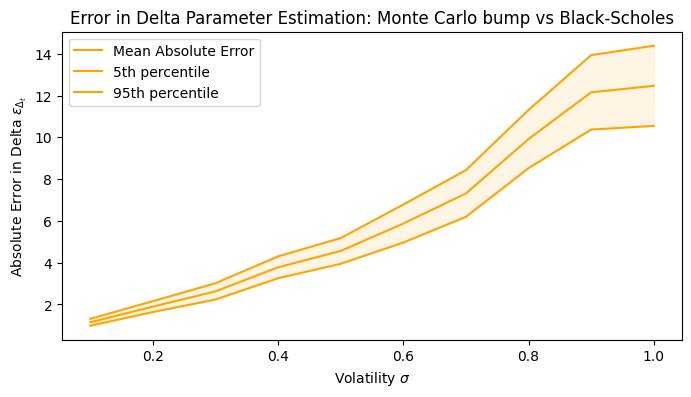

In [134]:
# Given parameters
N = 50
K = 99
r = 0.06
S0 = 100
T = 1
M=100
runs = 100
delta_t = T / N  
bump = 1
error_array = np.zeros((10, 100))

plt.figure(figsize=(8, 4))
volatilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for index, run in enumerate(range(runs)):
    deltas_binom = []
    deltas_BlackScholes = []
    errors = []

    for σ in volatilities:
        option_value = priceOption(S0, r, delta_t, N, σ, K, M, "call")[0]
        option_bumped  = priceOption(S0, r, delta_t, N, σ, K, M, "call")[0]
        delta_MC_bump = (np.array(option_bumped) - np.array(option_value))/bump
        BS_delta = blackScholes(S0, K, 0, T, r, σ)[1]
        deltas_BlackScholes.append(BS_delta)
        
        error = np.abs(BS_delta - delta_MC_bump)
        errors.append(error)

    error_array[:, index] = errors

# Calculate mean and standard deviation of errors
mean_errors = np.mean(error_array, axis=1)
std_errors = np.std(error_array, axis=1)

# Calculate 95% confidence intervals
confidence_interval = 1.96 * (std_errors / np.sqrt(runs))

# Plotting
plt.plot(volatilities, mean_errors, label='Mean Absolute Error', color='orange')
plt.plot(volatilities, mean_errors-confidence_interval,label = '5th percentile', color = 'orange')
plt.plot(volatilities, mean_errors+confidence_interval,label = '95th percentile', color = 'orange')
plt.fill_between(volatilities, (mean_errors-confidence_interval), (mean_errors+confidence_interval), color='orange', alpha=0.1)

plt.title('Error in Delta Parameter Estimation: Monte Carlo bump vs Black-Scholes')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Absolute Error in Delta $\epsilon_{\Delta_{t}}$')
plt.legend()
plt.show()

## Hedge param delta error MC vs. Black-Scholes using Bump and revalue, same and different seed

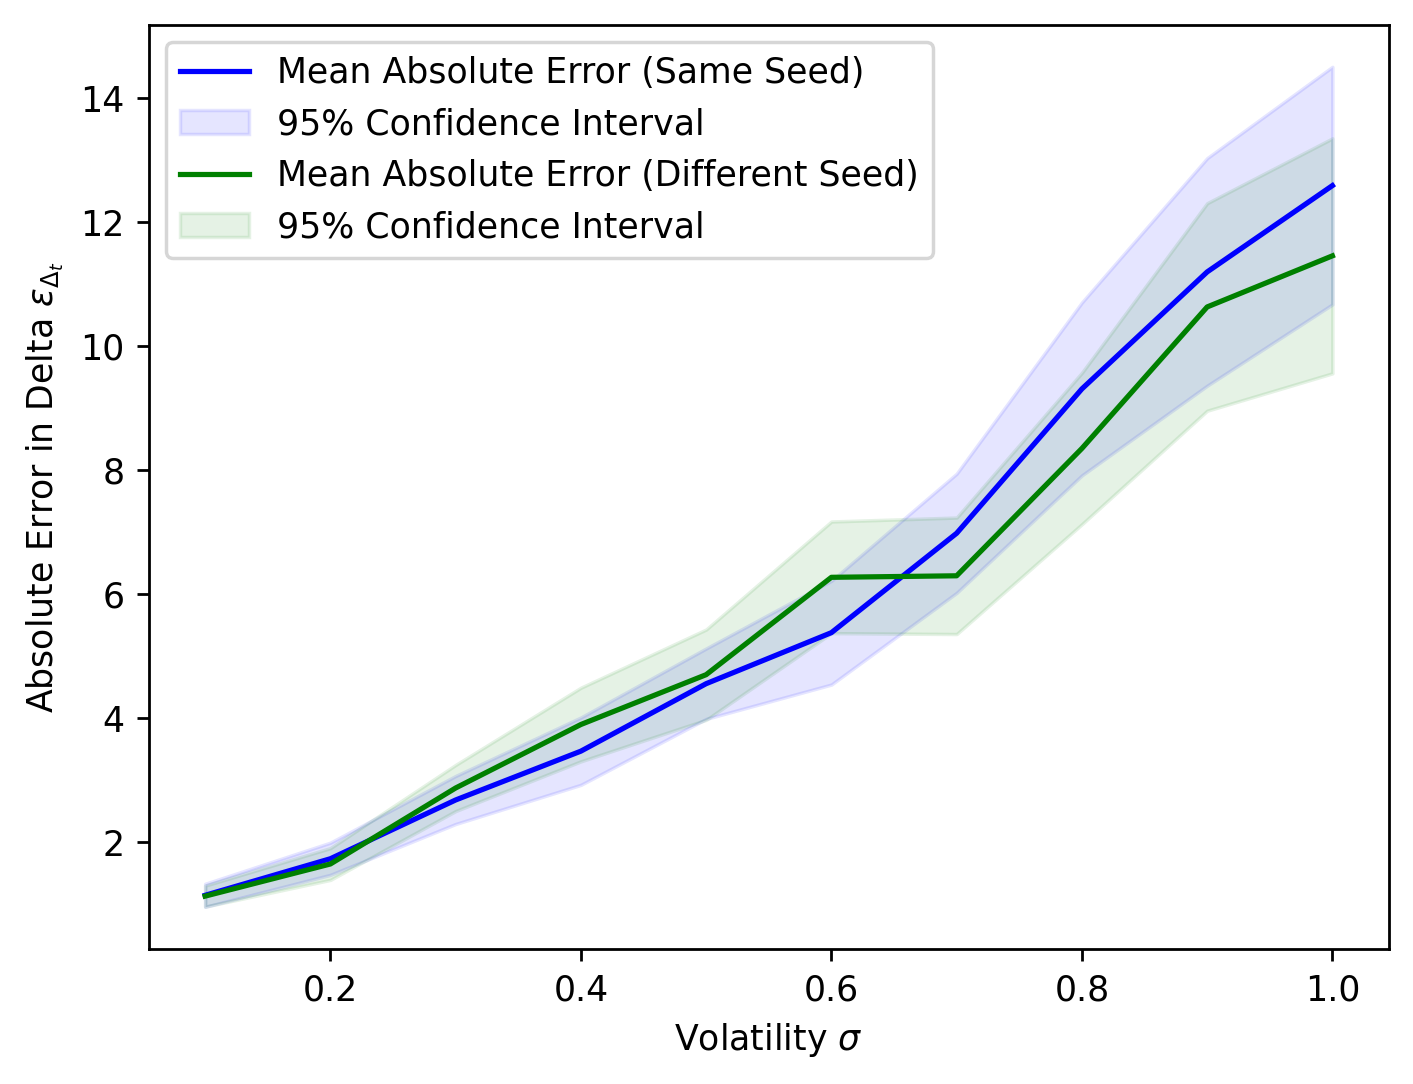

In [135]:
# Given parameters
N = 50
K = 99
r = 0.06
S0 = 100
T = 1
M = 100
runs = 100
delta_t = T / N  
bump = 1
error_array_same_seed = np.zeros((len(volatilities), 100))
error_array_diff_seed = np.zeros((len(volatilities), 100))

plt.figure(dpi=250)
volatilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for index, run in enumerate(range(runs)):
    errors_same_seed = []
    errors_diff_seed = []

    for σ in volatilities:
        seed = 42  # Set the same seed for reproducibility
        option_value = priceOption(S0, r, delta_t, N, σ, K, M, "call", seed)[0]
        option_bumped_same_seed  = priceOption(S0, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        seed = len(volatilities)
        option_bumped_diff_seed = priceOption(S0, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        delta_MC_bump_same_seed = (np.array(option_bumped_same_seed) - np.array(option_value)) / bump
        delta_MC_bump_diff_seed = (np.array(option_bumped_diff_seed) - np.array(option_value)) / bump
        
        BS_delta = blackScholes(S0, K, 0, T, r, σ)[1]
        
        error_same_seed = np.abs(BS_delta - delta_MC_bump_same_seed)
        errors_same_seed.append(error_same_seed)
        
        error_diff_seed = np.abs(BS_delta - delta_MC_bump_diff_seed)
        errors_diff_seed.append(error_diff_seed)

    error_array_same_seed[:, index] = errors_same_seed
    error_array_diff_seed[:, index] = errors_diff_seed

# Calculate mean and standard deviation of error
mean_errors_same_seed = np.mean(error_array_same_seed, axis=1)
std_errors_same_seed = np.std(error_array_same_seed, axis=1)
mean_errors_diff_seed = np.mean(error_array_diff_seed, axis=1)
std_errors_diff_seed = np.std(error_array_diff_seed, axis=1)

# Calculate 95% confidence intervals
confidence_interval_same_seed = 1.96 * (std_errors_same_seed / np.sqrt(runs))
confidence_interval_diff_seed = 1.96 * (std_errors_diff_seed / np.sqrt(runs))

# Plotting
plt.plot(volatilities, mean_errors_same_seed, label='Mean Absolute Error (Same Seed)', color='blue')
plt.fill_between(volatilities, mean_errors_same_seed-confidence_interval_same_seed, mean_errors_same_seed+confidence_interval_same_seed, color='blue', alpha=0.1, label= '95% Confidence Interval')

plt.plot(volatilities, mean_errors_diff_seed, label='Mean Absolute Error (Different Seed)', color='green')
plt.fill_between(volatilities, mean_errors_diff_seed-confidence_interval_diff_seed, mean_errors_diff_seed+confidence_interval_diff_seed, color='green', alpha=0.1, label= '95% Confidence Interval')

# plt.title('Error in Delta Parameter Estimation: Monte Carlo with Same and Different Seeds vs Black-Scholes')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Absolute Error in Delta $\epsilon_{\Delta_{t}}$')
plt.legend()
plt.show()


0.11092586216302835
0.11092586216302835


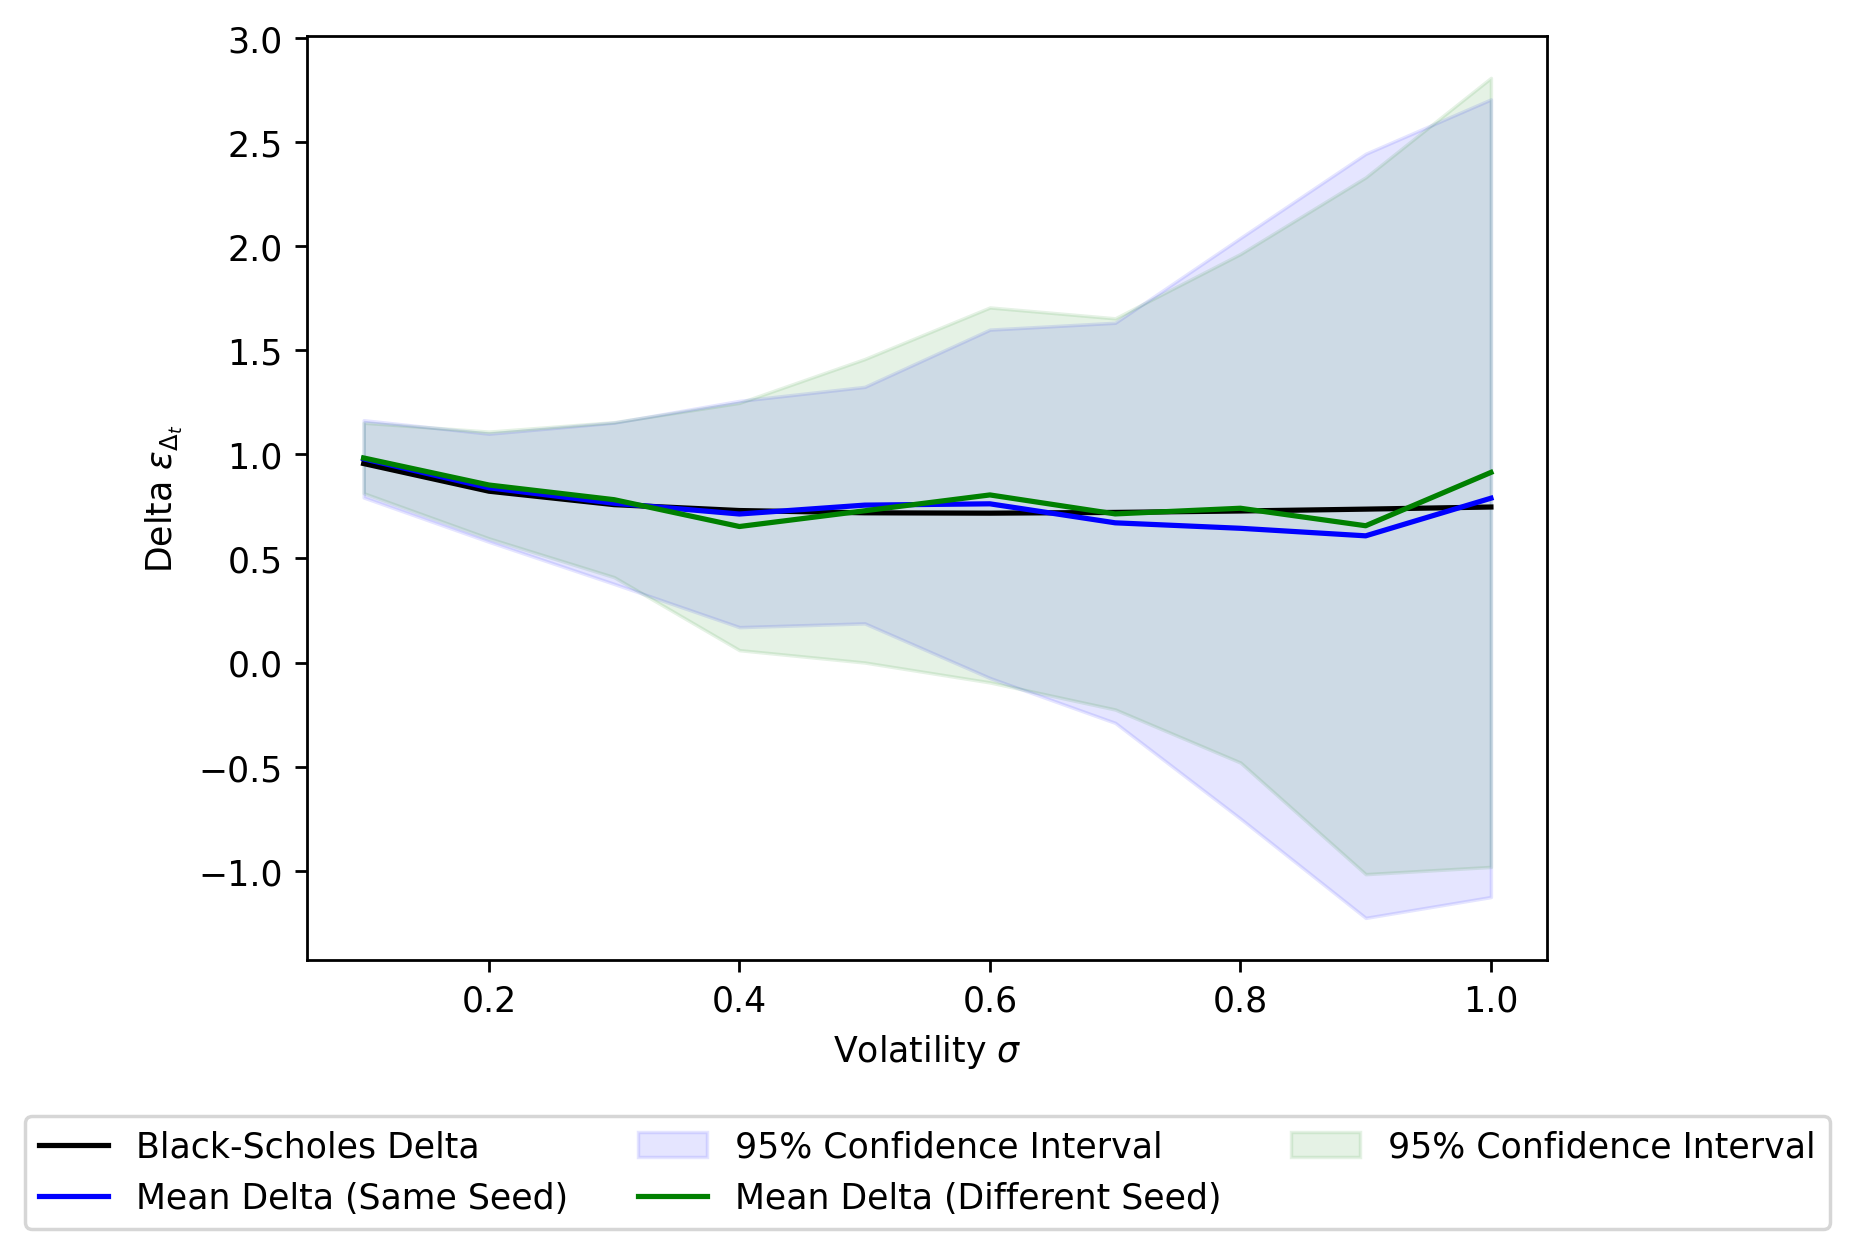

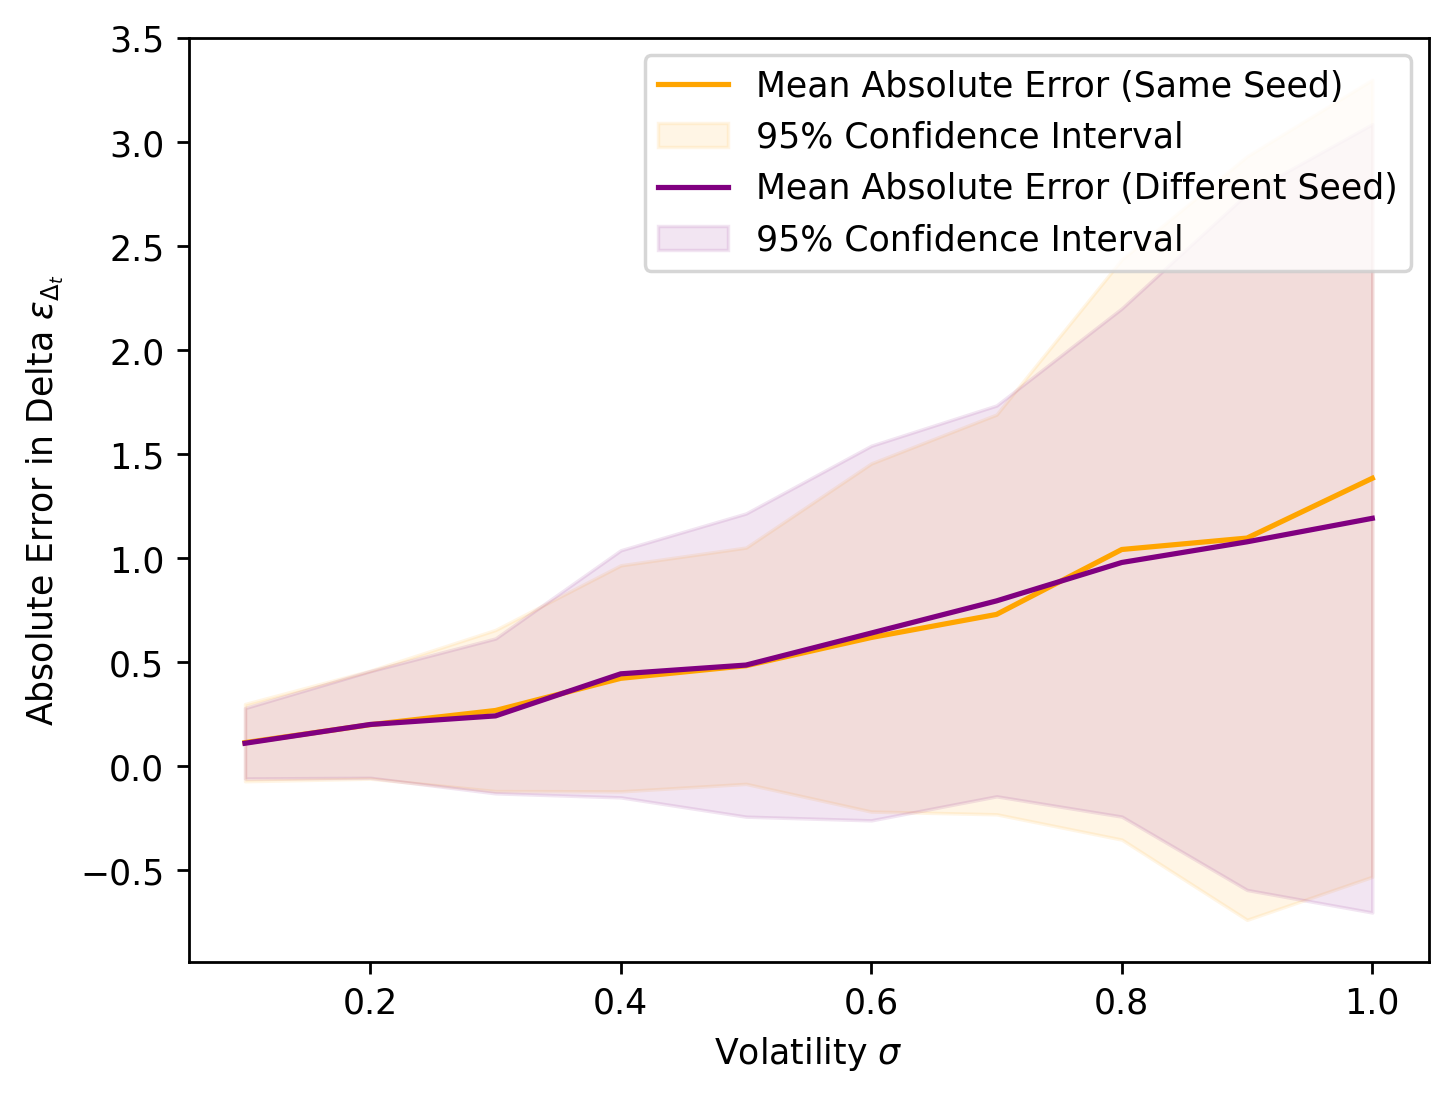

In [136]:
# Given parameters
N = 50
K = 90
r = 0.06
S0 = 100
T = 1
M = 10000
runs = 100
delta_t = T / N  
bump = 1

volatilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
error_array_same_seed = np.zeros((len(volatilities), runs))
error_array_diff_seed = np.zeros((len(volatilities), runs))
delta_array_same_seed = np.zeros((len(volatilities), runs))
delta_array_diff_seed = np.zeros((len(volatilities), runs))


plt.figure(dpi=250)

for index, run in enumerate(range(runs)):
    delta_bump_same_seed_list = []
    delta_bump_different_seed_list = []
    pathwise_deltas = []
    pathwise_deltas_smoothed = [] 
    errors_same_seed = []
    errors_diff_seed = []

    for σ in volatilities:
        seed = 38
        option_value = priceOption(S0, r, delta_t, N, σ, K, M, "call", seed)[0]
        option_bumped_same_seed = priceOption(S0 + bump, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        seed = 52
        option_bumped_diff_seed = priceOption(S0 + bump, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        delta_MC_bump_same_seed = ((option_bumped_same_seed - option_value) / bump)
        delta_MC_bump_diff_seed = ((option_bumped_diff_seed - option_value) / bump)

        delta_bump_same_seed_list.append(delta_MC_bump_same_seed)
        delta_bump_different_seed_list.append(delta_MC_bump_diff_seed)
        
        BS_delta = blackScholes(S0, K, 0, T, r, σ)[1]
        
        error_same_seed = np.abs(BS_delta - delta_MC_bump_same_seed)
        errors_same_seed.append(error_same_seed)
        
        error_diff_seed = np.abs(BS_delta - delta_MC_bump_diff_seed)
        errors_diff_seed.append(error_diff_seed)

    delta_array_same_seed[:, index] = np.array(delta_bump_same_seed_list).flatten()
    delta_array_diff_seed[:, index] = np.array(delta_bump_different_seed_list).flatten()
    error_array_same_seed[:, index] = np.array(errors_same_seed).flatten()
    error_array_diff_seed[:, index] = np.array(errors_diff_seed).flatten()

# Calculate mean and standard deviation of error
mean_errors_same_seed = np.mean(error_array_same_seed, axis=1)
std_errors_same_seed = np.std(error_array_same_seed, axis=1)
mean_errors_diff_seed = np.mean(error_array_diff_seed, axis=1)
std_errors_diff_seed = np.std(error_array_diff_seed, axis=1)


# Calculate mean and standard deviation of delta MC
mean_delta_same_seed = np.mean(delta_array_same_seed, axis=1)
std_delta_same_seed = np.std(delta_array_same_seed, axis=1)
mean_delta_diff_seed = np.mean(delta_array_diff_seed, axis=1)
std_delta_diff_seed = np.std(delta_array_diff_seed, axis=1)


# Calculate 95% confidence intervals
confidence_interval_delta_same_seed = 1.96 * (std_delta_same_seed / np.sqrt(runs))
confidence_interval_delta_diff_seed = 1.96 * (std_delta_diff_seed / np.sqrt(runs))
confidence_interval_error_same_seed = 1.96 * (std_errors_same_seed / np.sqrt(runs))
confidence_interval_error_diff_seed = 1.96 * (std_errors_diff_seed / np.sqrt(runs))



# Plotting Delta
BS_deltas = [blackScholes(S0, K, 0, T, r, σ)[1] for σ in volatilities]
plt.plot(volatilities, BS_deltas, label='Black-Scholes Delta', color='black')
plt.plot(volatilities, mean_delta_same_seed, label='Mean Delta (Same Seed)', color='blue')
plt.fill_between(volatilities, mean_delta_same_seed-confidence_interval_same_seed, mean_delta_same_seed+confidence_interval_same_seed, color='blue', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_delta_diff_seed, label='Mean Delta (Different Seed)', color='green')
plt.fill_between(volatilities, mean_delta_diff_seed-confidence_interval_diff_seed, mean_delta_diff_seed+confidence_interval_diff_seed, color='green', alpha=0.1, label= '95% Confidence Interval')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Delta $\epsilon_{\Delta_{t}}$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)



# Plotting Errors
plt.figure(dpi=250)
plt.plot(volatilities, mean_errors_same_seed, label='Mean Absolute Error (Same Seed)', color='orange')
plt.fill_between(volatilities, mean_errors_same_seed-confidence_interval_same_seed, mean_errors_same_seed+confidence_interval_same_seed, color='orange', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_errors_diff_seed, label='Mean Absolute Error (Different Seed)', color='purple')
print(np.min(mean_errors_diff_seed))
plt.fill_between(volatilities, mean_errors_diff_seed-confidence_interval_diff_seed, mean_errors_diff_seed+confidence_interval_diff_seed, color='purple', alpha=0.1, label= '95% Confidence Interval')
print(np.min(mean_errors_diff_seed))
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Absolute Error in Delta $\epsilon_{\Delta_{t}}$')
plt.legend()
plt.show()


# plt.title('Error in Delta Parameter Estimation: Monte Carlo with Same and Different Seeds vs Black-Scholes')

## Delta error in case of digital option

In [137]:
def priceOption_digi(S0, r, delta_t, N, sigma, K, M, option_type, seed = 0):
    """
    Function to price the option using Monte Carlo simulation  
    Args:
        S0 : Initial stock price
        r : Risk-free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatility of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option ('call' or 'put')
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    np.random.seed(seed)
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = digital_option_payoff(stock_price_N, K, type = "call")
        else:
            pay_off  = digital_option_payoff(stock_price_N, K, type = "put")
        pay_offs[i] = pay_off
    
    # Calculate price option and standard error
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
  
    m, sd = np.mean(pay_offs * np.exp(-r*T)), np.std(pay_offs * np.exp(-r*T))
    h = 1.96 * sd / np.sqrt(M) # Confidence interval calculation
    ml, mu = m - h, m + h # Lower and upper bounds
    
    return price_option, std_error, ml, mu

In [138]:
@njit
def Pathwise_delta(S0, r, delta_t, N, σ, K, M, type= 'call', seed = 0, smooth = 'no'):
    T = N * delta_t
    np.random.seed(seed)
    deltas = np.zeros(M)
    for index, path in enumerate(range(M)):
        S_t = S0
        for timestep in range(N):
            Z = normal()
            S_t = S_t * np.exp((r - 0.5 * σ**2) * delta_t + σ * np.sqrt(delta_t) * Z)
        pay_off = digital_option_payoff(S_t, K, type = type, smooth=smooth)
        if pay_off == 1:
            delta_est = np.exp(-r*T) * (S_t / S0)
        else:
            delta_est = 0
        deltas[index] = delta_est

    return np.mean(deltas)

In [139]:
def calculate_Delta_likelihood_Digital(S0, K, r, sigma, T, delta_t, M, seed_value = 0):
    """
    Function to calculate the delta for Digital Option using Pathwise method

    Args:
        S0 : Stock price at time 0
        K : Strike price
        r : Risk free interest rate
        sigma : Volatality of the stock
        T : Maturity time
        M : Number of simulations
        delta_t : Time step
        seed_value (int, optional): Seed value for random number generation.Defaults to 0.

    Returns:
        delta : Delta value
    """
    np.random.seed(seed_value)
    delta = np.zeros(M)
    for i in range(M):
        S = euler_Method(S0, r, delta_t, int(T/delta_t), sigma)[-1]
        Y = (np.log(S/S0) - (r - 0.5 * sigma**2)*T)/(sigma**2 * T * S0)
        if S > K:
            delta[i] = np.exp(-r*T) * Y / (S0*sigma*np.sqrt(T))
        else:
            delta[i] = 0

    return np.mean(delta), confidence_interval(delta)

In [140]:
def confidence_interval(data):
        """
        Function to calculate confidence interval

        Args:
            data: Data for which confidence interval is to be calculated

        Returns:
                m-h, m+h : Lower and upper bounds of the confidence interval
        """
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m - h, m + h

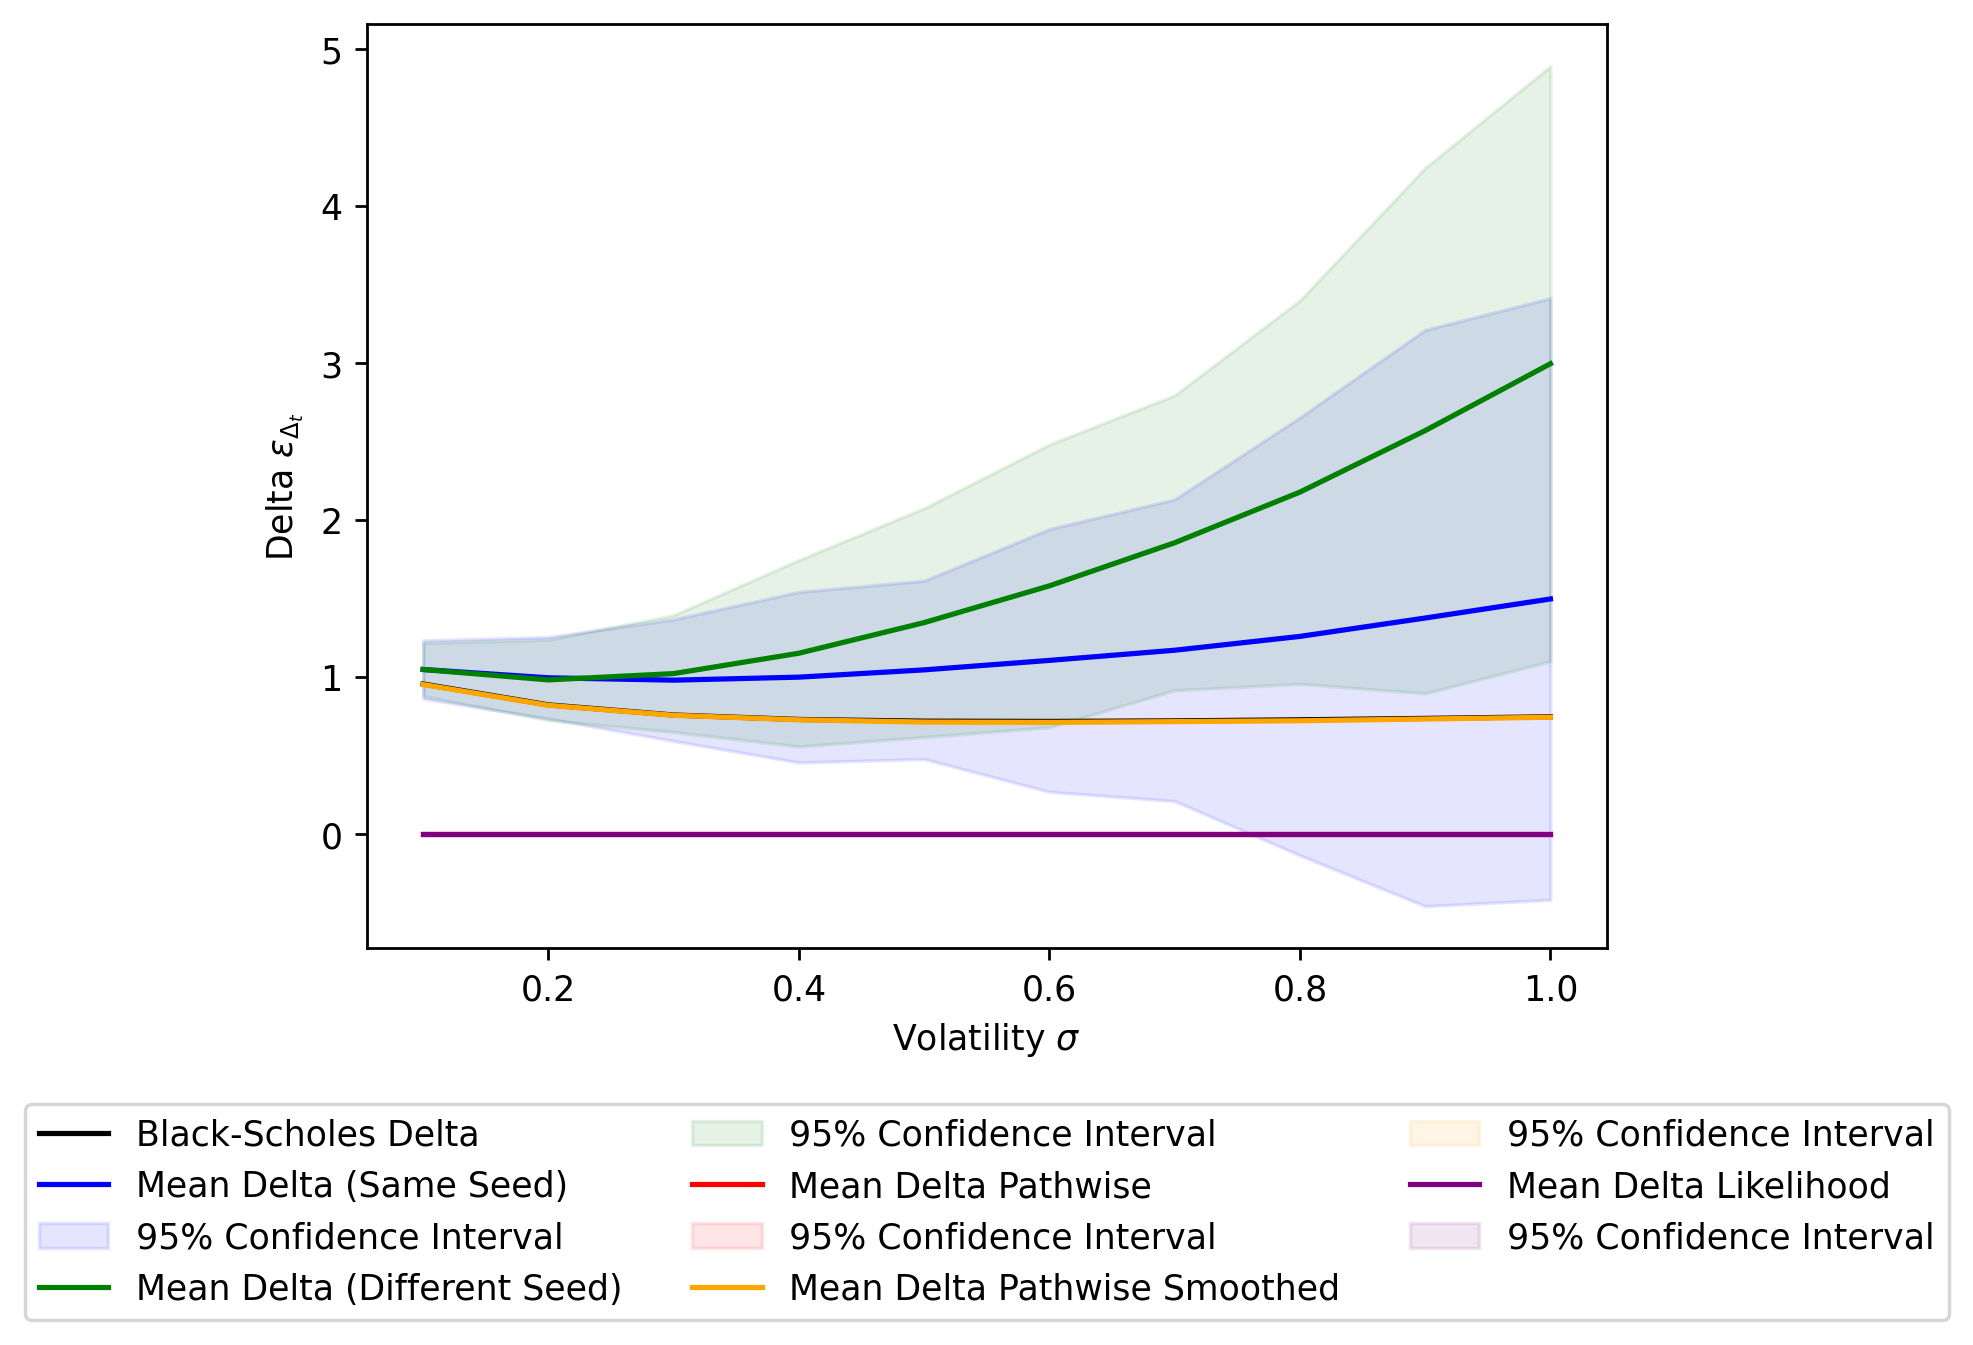

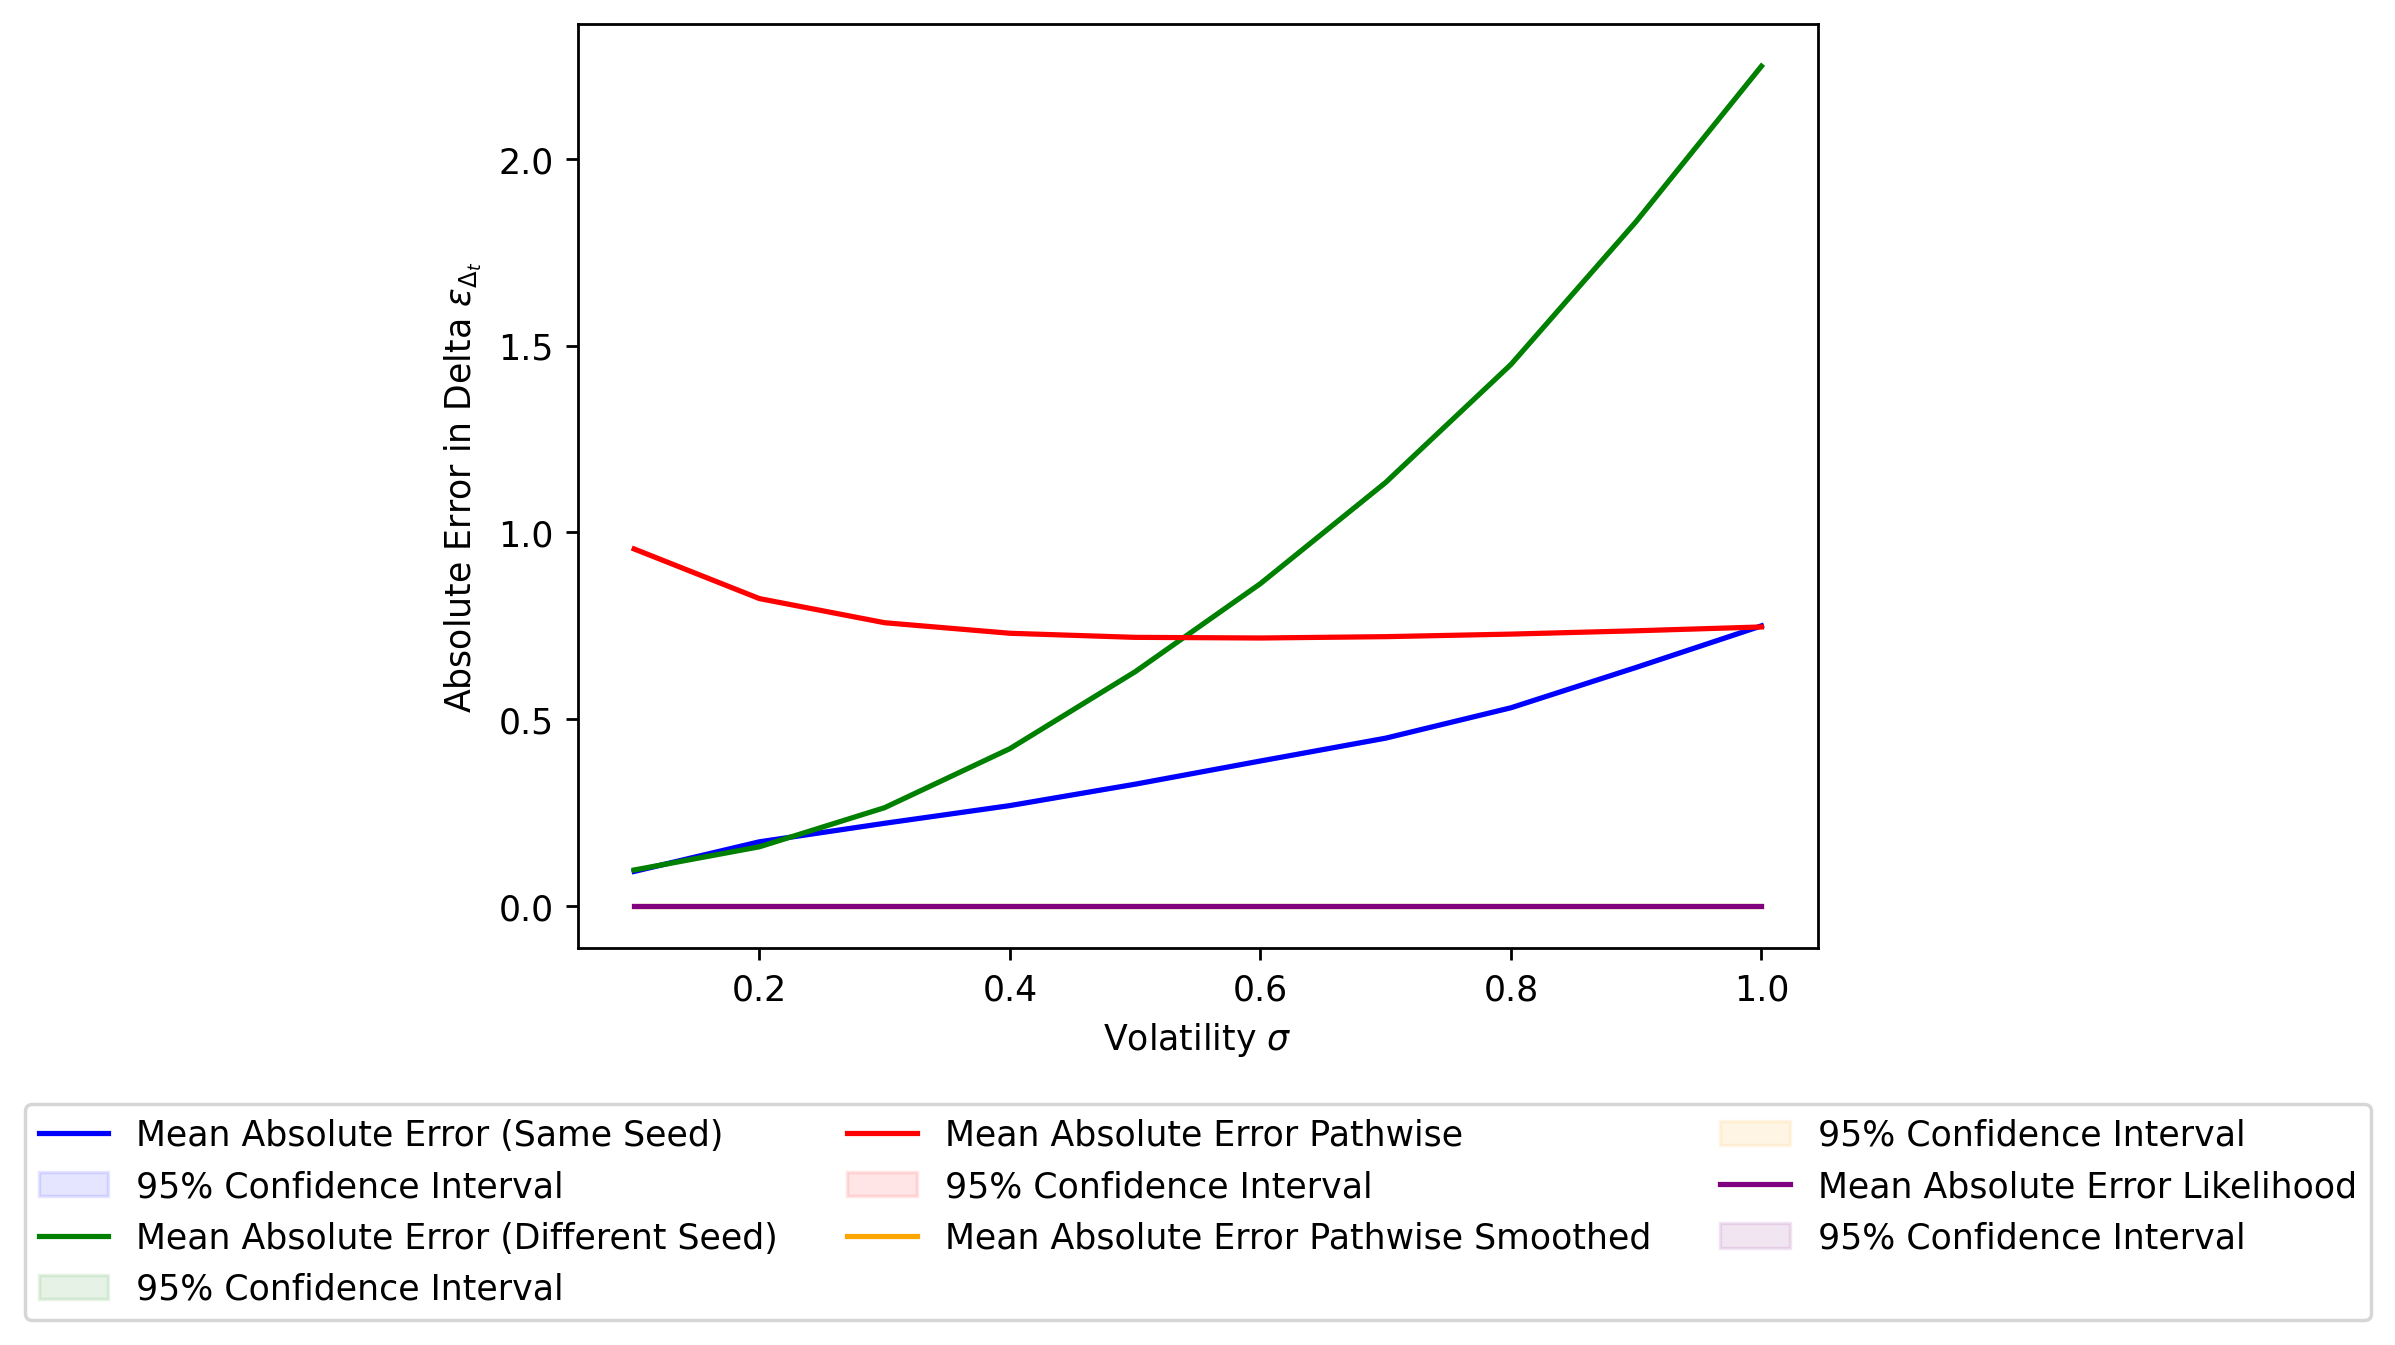

In [141]:
# Given parameters
N = 50
K = 90
r = 0.06
S0 = 100
T = 1
M = 10000
runs = 100
delta_t = T / N  
bump = 1

volatilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
error_array_same_seed = np.zeros((len(volatilities), runs))
error_array_diff_seed = np.zeros((len(volatilities), runs))
error_array_pathwise = np.zeros((len(volatilities), runs))
error_array_pathwise_smoothed = np.zeros((len(volatilities), runs))
error_array_likelihood = np.zeros((len(volatilities), runs))
delta_array_same_seed = np.zeros((len(volatilities), runs))
delta_array_diff_seed = np.zeros((len(volatilities), runs))
delta_array_pathwise = np.zeros((len(volatilities), runs))
delta_array_pathwise_smoothed = np.zeros((len(volatilities), runs))
delta_array_likelihood = np.zeros((len(volatilities), runs))


plt.figure(dpi=250)

for index, run in enumerate(range(runs)):
    delta_bump_same_seed_list = []
    delta_bump_different_seed_list = []
    pathwise_deltas = []
    pathwise_deltas_smoothed = []
    likelihood_deltas = []
    errors_same_seed = []
    errors_diff_seed = []
    errors_pathwise = []
    errors_pathwise_smoothed = []
    errors_likelihood = []


    for σ in volatilities:
        seed = 38
        option_value = priceOption_digi(S0, r, delta_t, N, σ, K, M, "call", seed)[0]
        option_bumped_same_seed = priceOption_digi(S0 + bump, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        seed = 52
        option_bumped_diff_seed = priceOption_digi(S0 + bump, r, delta_t, N, σ, K, M, "call", seed)[0]
        
        delta_MC_bump_same_seed = ((option_bumped_same_seed - option_value) / bump).flatten()
        delta_MC_bump_diff_seed = ((option_bumped_diff_seed - option_value) / bump).flatten()
        pathwise_delta = Pathwise_delta(S0, r, delta_t, N, σ, K, M, 'call', seed)
        pathwise_delta_smooth = Pathwise_delta(S0, r, delta_t, N, σ, K, M, 'call', seed, smooth='yes')
        likelihood_delta = calculate_Delta_likelihood_Digital(S0, K, r, σ, T, delta_t, M, seed)[0]

        delta_bump_same_seed_list.append(delta_MC_bump_same_seed)
        delta_bump_different_seed_list.append(delta_MC_bump_diff_seed)
        pathwise_deltas.append(pathwise_delta)
        pathwise_deltas_smoothed.append(pathwise_delta_smooth)
        likelihood_deltas.append(likelihood_delta)

        
        BS_delta = blackScholes(S0, K, 0, T, r, σ)[1]
        
        error_same_seed = np.abs(BS_delta - delta_MC_bump_same_seed)
        errors_same_seed.append(error_same_seed)
        
        error_diff_seed = np.abs(BS_delta - delta_MC_bump_diff_seed)
        errors_diff_seed.append(error_diff_seed)

        error_pathwise = np.abs(BS_delta - pathwise_delta)
        errors_pathwise.append(error_pathwise)

        error_pathwise_smoothed = np.abs(BS_delta - pathwise_delta_smooth)
        errors_pathwise_smoothed.append(error_pathwise_smoothed)

        error_likelihood = np.abs(BS_delta - likelihood_delta)
        errors_likelihood.append(error_likelihood)

    delta_array_same_seed[:, index] = np.array(delta_bump_same_seed_list).flatten()
    delta_array_diff_seed[:, index] = np.array(delta_bump_different_seed_list).flatten()
    delta_array_pathwise[:, index] = pathwise_deltas
    delta_array_pathwise_smoothed[:, index] = pathwise_deltas_smoothed
    error_array_same_seed[:, index] = np.array(errors_same_seed).flatten()
    error_array_diff_seed[:, index] = np.array(errors_diff_seed).flatten()
    error_array_pathwise[:, index] = np.array(errors_pathwise).flatten()


# Calculate mean and standard deviation of delta MC
mean_delta_same_seed = np.mean(delta_array_same_seed, axis=1)
std_delta_same_seed = np.std(delta_array_same_seed, axis=1)
mean_delta_diff_seed = np.mean(delta_array_diff_seed, axis=1)
std_delta_diff_seed = np.std(delta_array_diff_seed, axis=1)

# Calculate mean and standard deviation of delta Pathwise
mean_delta_pathwise = np.mean(delta_array_pathwise, axis=1)
mean_delta_pathwise_smoothed = np.mean(delta_array_pathwise_smoothed, axis=1)
std_delta_pathwise = np.std(delta_array_pathwise, axis=1)
std_delta_pathwise_smoothed = np.std(delta_array_pathwise_smoothed, axis=1)

# Calculate mean and standard deviation of delta likelihood
mean_delta_likelihood = np.mean(delta_array_likelihood, axis=1)
std_delta_likelihood = np.std(delta_array_likelihood, axis=1)

# Calculate mean and standard deviation of error for Monte Carlo
mean_errors_same_seed = np.mean(error_array_same_seed, axis=1)
std_errors_same_seed = np.std(error_array_same_seed, axis=1)
mean_errors_diff_seed = np.mean(error_array_diff_seed, axis=1)
std_errors_diff_seed = np.std(error_array_diff_seed, axis=1)

# Calculate mean and standard deviation of error for Pathwise
mean_errors_pathwise = np.mean(error_array_pathwise, axis=1)
std_errors_pathwise = np.std(error_array_pathwise, axis=1)

# Calculate mean and standard deviation of error for Pathwise Smoothed
mean_errors_pathwise_smoothed = np.mean(error_array_pathwise_smoothed, axis=1)
std_errors_pathwise_smoothed = np.std(error_array_pathwise_smoothed, axis=1)

# Calculate mean and standard deviation of error for likelihood
mean_errors_likelihood = np.mean(error_array_likelihood, axis=1)
std_errors_likelihood = np.std(error_array_likelihood, axis=1)



# Calculate 95% confidence intervals delta
confidence_interval_delta_same_seed = 1.96 * (std_delta_same_seed / np.sqrt(runs))
confidence_interval_delta_diff_seed = 1.96 * (std_delta_diff_seed / np.sqrt(runs))
confidence_interval_delta_pathwise = 1.96 * (std_delta_pathwise / np.sqrt(runs))
confidence_interval_delta_pathwise_smoothed = 1.96 * (std_delta_pathwise_smoothed / np.sqrt(runs))
confidence_interval_delta_likelihood = 1.96 * (std_delta_likelihood / np.sqrt(runs))

# Calculate 95% confidence intervals error
confidence_interval_error_same_seed = 1.96 * (std_errors_same_seed / np.sqrt(runs))
confidence_interval_error_diff_seed = 1.96 * (std_errors_diff_seed / np.sqrt(runs))
confidence_interval_error_pathwise = 1.96 * (std_errors_pathwise / np.sqrt(runs))
confidence_interval_error_pathwise_smoothed = 1.96 * (std_errors_pathwise_smoothed / np.sqrt(runs))
confidence_interval_error_likelihood = 1.96 * (std_errors_likelihood / np.sqrt(runs))




# Plotting Delta
BS_deltas = [blackScholes(S0, K, 0, T, r, σ)[1] for σ in volatilities]
plt.plot(volatilities, BS_deltas, label='Black-Scholes Delta', color='black')
plt.plot(volatilities, mean_delta_same_seed, label='Mean Delta (Same Seed)', color='blue')
plt.fill_between(volatilities, mean_delta_same_seed-confidence_interval_same_seed, mean_delta_same_seed+confidence_interval_same_seed, color='blue', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_delta_diff_seed, label='Mean Delta (Different Seed)', color='green')
plt.fill_between(volatilities, mean_delta_diff_seed-confidence_interval_diff_seed, mean_delta_diff_seed+confidence_interval_diff_seed, color='green', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_delta_pathwise, label='Mean Delta Pathwise', color='red')
plt.fill_between(volatilities, mean_delta_pathwise-confidence_interval_delta_pathwise, mean_delta_pathwise+confidence_interval_delta_pathwise, color='red', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_delta_pathwise_smoothed, label='Mean Delta Pathwise Smoothed', color='orange')
plt.fill_between(volatilities, mean_delta_pathwise_smoothed-confidence_interval_delta_pathwise_smoothed, mean_delta_pathwise_smoothed+confidence_interval_delta_pathwise_smoothed, color='orange', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_delta_likelihood, label='Mean Delta Likelihood', color='purple')
plt.fill_between(volatilities, mean_delta_likelihood-confidence_interval_delta_likelihood, mean_delta_likelihood+confidence_interval_delta_likelihood, color='purple', alpha=0.1, label= '95% Confidence Interval')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Delta $\epsilon_{\Delta_{t}}$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)



# Plotting Errors
plt.figure(dpi=250)
plt.plot(volatilities, mean_errors_same_seed, label='Mean Absolute Error (Same Seed)', color='blue')
plt.fill_between(volatilities, mean_errors_same_seed-confidence_interval_error_same_seed, mean_errors_same_seed+confidence_interval_error_same_seed, color='blue', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_errors_diff_seed, label='Mean Absolute Error (Different Seed)', color='green')
plt.fill_between(volatilities, mean_errors_diff_seed-confidence_interval_error_diff_seed, mean_errors_diff_seed+confidence_interval_error_diff_seed, color='green', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_errors_pathwise, label='Mean Absolute Error Pathwise', color='red')
plt.fill_between(volatilities, mean_errors_pathwise-confidence_interval_error_pathwise, mean_errors_pathwise+confidence_interval_error_pathwise, color='red', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_errors_pathwise_smoothed, label='Mean Absolute Error Pathwise Smoothed', color='orange')
plt.fill_between(volatilities, mean_errors_pathwise_smoothed-confidence_interval_error_pathwise_smoothed, mean_errors_pathwise_smoothed+confidence_interval_error_pathwise_smoothed, color='orange', alpha=0.1, label= '95% Confidence Interval')
plt.plot(volatilities, mean_errors_likelihood, label='Mean Absolute Error Likelihood', color='purple')
plt.fill_between(volatilities, mean_errors_likelihood-confidence_interval_error_likelihood, mean_errors_likelihood+confidence_interval_error_likelihood, color='purple', alpha=0.1, label= '95% Confidence Interval')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Absolute Error in Delta $\epsilon_{\Delta_{t}}$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)


# plt.title('Error in Delta Parameter Estimation: Monte Carlo with Same and Different Seeds vs Black-Scholes')

## Pathwise smoothed and not smoothed

In [142]:
@njit
def Pathwise_delta(S0, r, delta_t, N, σ, K, M, type= 'call', seed = 0, smooth = 'no'):
    T = N * delta_t
    np.random.seed(seed)
    deltas = np.zeros(M)
    for index, path in enumerate(range(M)):
        S_t = S0
        for timestep in range(N):
            Z = normal()
            S_t = S_t * np.exp((r - 0.5 * σ**2) * delta_t + σ * np.sqrt(delta_t) * Z)
        pay_off = digital_option_payoff(S_t, K, type = type, smooth=smooth)
        if pay_off == 1:
            delta_est = np.exp(-r*T) * (S_t / S0)
        else:
            delta_est = 0
        deltas[index] = delta_est

    return np.mean(deltas)

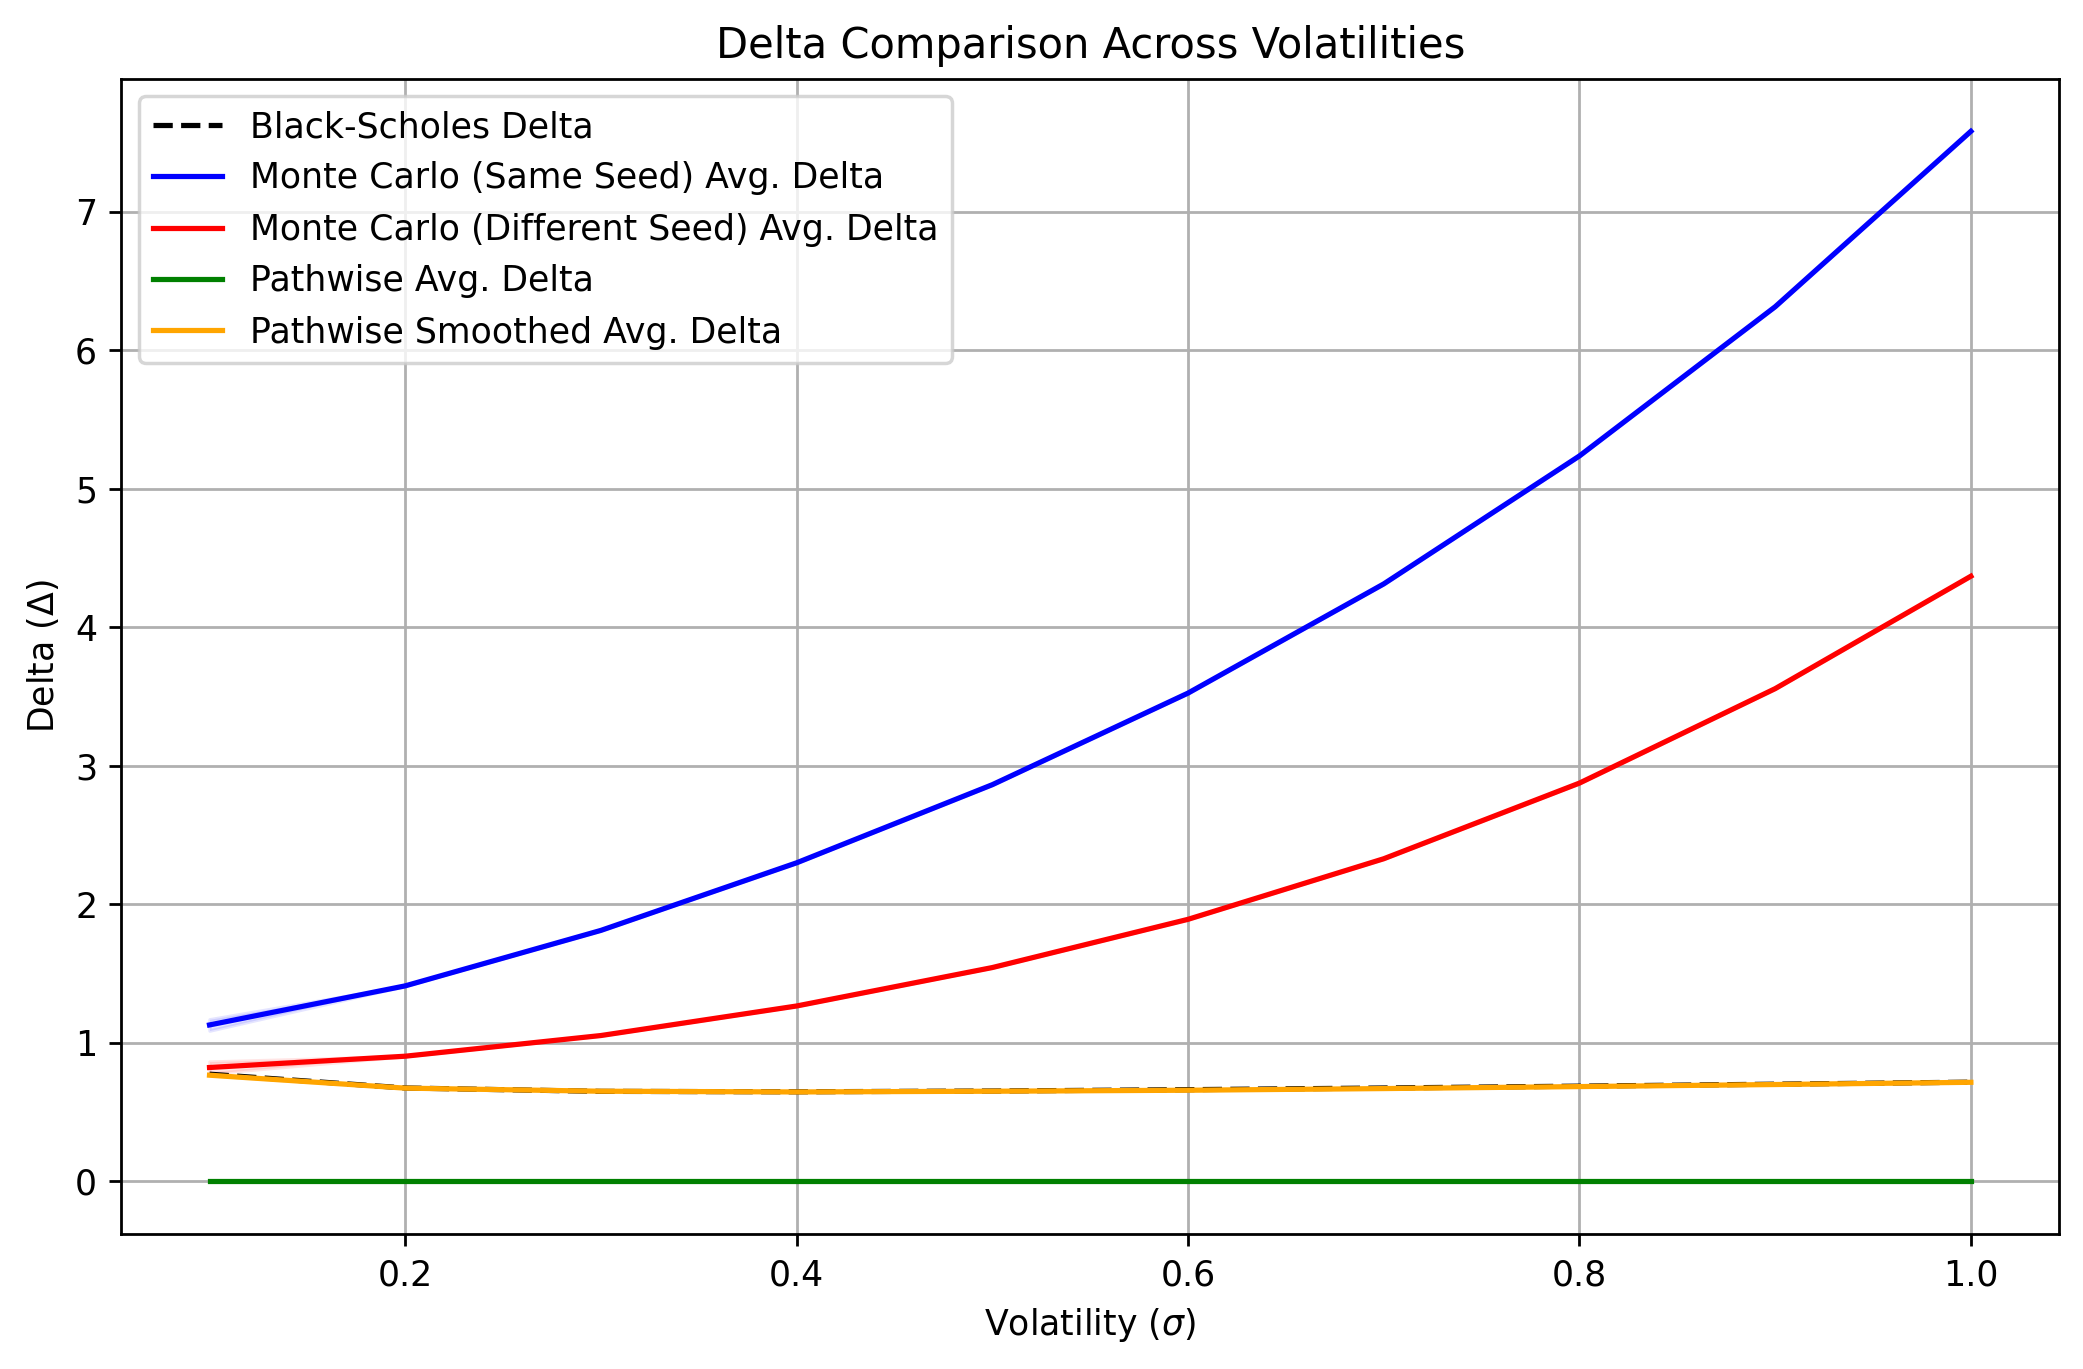

In [143]:
# Given parameters
N = 50
K = 99
r = 0.06
S0 = 100
T = 1
M = 10000
runs = 10
delta_t = T / N
bump = 0.5
volatilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

delta_array_same_seed = np.zeros((len(volatilities), runs))
delta_array_diff_seed = np.zeros((len(volatilities), runs))
delta_array_pathwise = np.zeros((len(volatilities), runs))
delta_array_pathwise_smoothed = np.zeros((len(volatilities), runs))

for index in range(runs):
    deltas_same_seed = []
    deltas_diff_seed = []
    pathwise_deltas = []
    pathwise_deltas_smoothed = []

    for σ in volatilities:
        seed = 42
        option_value = priceOption_digi(S0, r, delta_t, N, σ, K, M, 'call', seed)[0]
        option_bumped = priceOption_digi(S0 + bump, r, delta_t, N, σ, K, M, 'call', seed)[0]
        delta_MC_same_seed = (option_bumped - option_value) / bump
        pathwise_delta = Pathwise_delta(S0, r, delta_t, N, σ, K, M, 'call', seed)
        pathwise_delta_smooth = Pathwise_delta(S0, r, delta_t, N, σ, K, M, 'call', seed, smooth='yes')

        deltas_same_seed.append(delta_MC_same_seed)
        pathwise_deltas.append(pathwise_delta)
        pathwise_deltas_smoothed.append(pathwise_delta_smooth)

        seed = 29
        option_bumped_diff = priceOption_digi(S0 + bump, r, delta_t, N, σ, K, M, 'call', seed)[0]
        delta_MC_diff_seed = (option_bumped_diff - option_value) / bump
        deltas_diff_seed.append(delta_MC_diff_seed)

    delta_array_same_seed[:, index] = deltas_same_seed
    delta_array_diff_seed[:, index] = deltas_diff_seed
    delta_array_pathwise[:, index] = pathwise_deltas
    delta_array_pathwise_smoothed[:, index] = pathwise_deltas_smoothed

avg_delta_same_seed = np.mean(delta_array_same_seed, axis=1)
avg_delta_diff_seed = np.mean(delta_array_diff_seed, axis=1)
avg_delta_pathwise = np.mean(delta_array_pathwise, axis=1)
avg_delta_pathwise_smoothed = np.mean(delta_array_pathwise_smoothed, axis=1)

std_delta_same_seed = np.std(delta_array_same_seed, axis=1)
std_delta_diff_seed = np.std(delta_array_diff_seed, axis=1)
std_delta_pathwise = np.std(delta_array_pathwise, axis=1)
std_delta_pathwise_smoothed = np.std(delta_array_pathwise_smoothed, axis=1)

confidence_interval_same_seed = 1.96 * (std_delta_same_seed / np.sqrt(runs))
confidence_interval_diff_seed = 1.96 * (std_delta_diff_seed / np.sqrt(runs))
confidence_interval_pathwise = 1.96 * (std_delta_pathwise / np.sqrt(runs))
confidence_interval_pathwise_smoothed = 1.96 * (std_delta_pathwise_smoothed / np.sqrt(runs))

# Plotting
plt.figure(figsize=(10, 6), dpi=250)

BS_deltas = [blackScholes(S0, K, 0, T, r, σ)[1] for σ in volatilities]
plt.plot(volatilities, BS_deltas, label='Black-Scholes Delta', color='black', linestyle='--')
plt.plot(volatilities, avg_delta_same_seed, label='Monte Carlo (Same Seed) Avg. Delta', color='blue')
plt.fill_between(volatilities, avg_delta_same_seed - confidence_interval_same_seed, avg_delta_same_seed + confidence_interval_same_seed, color='blue', alpha=0.1)
plt.plot(volatilities, avg_delta_diff_seed, label='Monte Carlo (Different Seed) Avg. Delta', color='red')
plt.fill_between(volatilities, avg_delta_diff_seed - confidence_interval_diff_seed, avg_delta_diff_seed + confidence_interval_diff_seed, color='red', alpha=0.1)
plt.plot(volatilities, avg_delta_pathwise, label='Pathwise Avg. Delta', color='green')
plt.fill_between(volatilities, avg_delta_pathwise - confidence_interval_pathwise, avg_delta_pathwise + confidence_interval_pathwise, color='green', alpha=0.1)
plt.plot(volatilities, avg_delta_pathwise_smoothed, label='Pathwise Smoothed Avg. Delta', color='orange')
plt.fill_between(volatilities, avg_delta_pathwise_smoothed - confidence_interval_pathwise_smoothed, avg_delta_pathwise_smoothed + confidence_interval_pathwise_smoothed, color='orange', alpha=0.1)

plt.xlabel('Volatility ($\sigma$)')
plt.ylabel('Delta ($\Delta$)')
plt.title('Delta Comparison Across Volatilities')
plt.legend()
plt.grid(True)
plt.show()

## Experiment

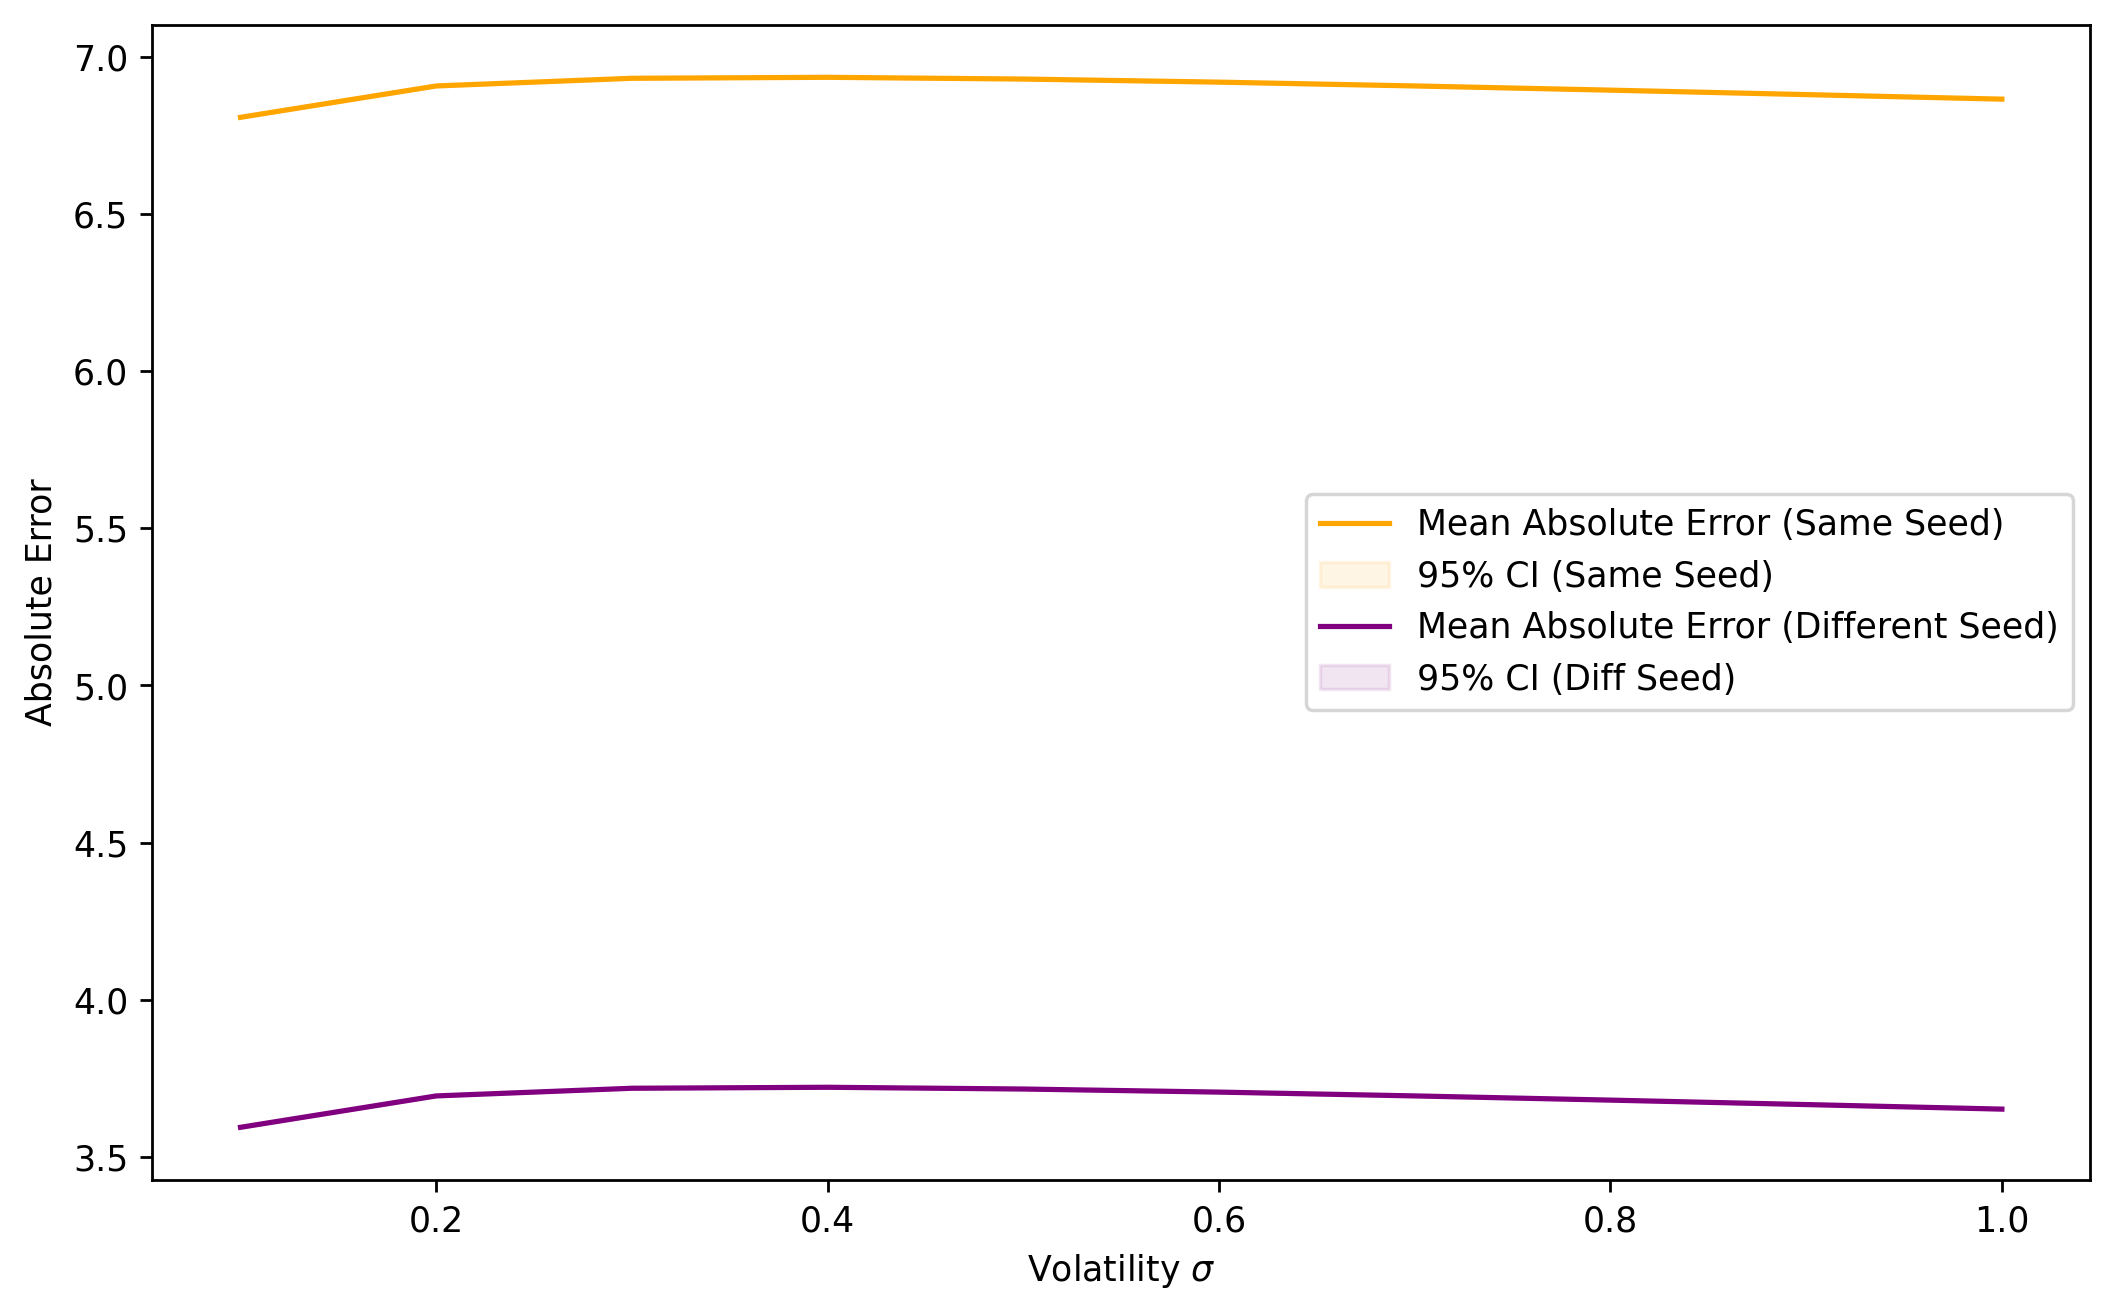

In [144]:

# Given parameters
N = 50
K = 99
r = 0.06
S0 = 100
T = 1
M = 10000
runs = 10
delta_t = T / N  
bump = 0.5
volatilities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Initialize arrays for absolute errors
error_array_same_seed = np.zeros((len(volatilities), runs)) 
error_array_diff_seed = np.zeros((len(volatilities), runs))

for index in range(runs):
    errors_same_seed = []
    errors_diff_seed = []

    for σ in volatilities:
        # Calculate deltas and Black-Scholes delta
        # (The calculations for option_value, option_bumped_same_seed, option_bumped_diff_seed remain the same)
        
        BS_delta = blackScholes(S0, K, 0, T, r, σ)[1]  # Calculate Black-Scholes delta once for each volatility
        
        # Calculate absolute errors
        error_same_seed = np.abs(delta_MC_same_seed - BS_delta)
        error_diff_seed = np.abs(delta_MC_diff_seed - BS_delta)
        
        errors_same_seed.append(error_same_seed)
        errors_diff_seed.append(error_diff_seed)
    
    error_array_same_seed[:, index] = errors_same_seed
    error_array_diff_seed[:, index] = errors_diff_seed

# Calculate mean and standard deviation of errors
mean_errors_same_seed = np.mean(error_array_same_seed, axis=1)
std_errors_same_seed = np.std(error_array_same_seed, axis=1)
mean_errors_diff_seed = np.mean(error_array_diff_seed, axis=1)
std_errors_diff_seed = np.std(error_array_diff_seed, axis=1)

# Calculate 95% confidence intervals
confidence_interval_same_seed = 1.96 * (std_errors_same_seed / np.sqrt(runs))
confidence_interval_diff_seed = 1.96 * (std_errors_diff_seed / np.sqrt(runs))

# Plotting for absolute errors
plt.figure(figsize=(10, 6), dpi=250)
plt.plot(volatilities, mean_errors_same_seed, label='Mean Absolute Error (Same Seed)', color='orange')
plt.fill_between(volatilities, mean_errors_same_seed-confidence_interval_same_seed, mean_errors_same_seed+confidence_interval_same_seed, color='orange', alpha=0.1, label='95% CI (Same Seed)')

plt.plot(volatilities, mean_errors_diff_seed, label='Mean Absolute Error (Different Seed)', color='purple')
plt.fill_between(volatilities, mean_errors_diff_seed-confidence_interval_diff_seed, mean_errors_diff_seed+confidence_interval_diff_seed, color='purple', alpha=0.1, label='95% CI (Diff Seed)')

plt.xlabel('Volatility $\sigma$')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

Varying strike price, probably not right

In [145]:
# ## Varying strike price
# K = np.arange(80, 90,2)
# #volatility = 0.2
# T = 1.0
# r = 0.06
# S0 = 100 
# sigma = 0.2
# delta_t = 0.001
# M = 9000
# N = int(T/delta_t)
# option_value_MC = []
# option_value_MC_bumped = []
# black_scholes_prices = []
# black_scholes_deltas = []
# delta_bumped = []
# # bumps = [0.1,0,5,1,5,10,len(volatilities)]
# # bumps = [0.1,0,5,1,5,10,len(volatilities)]
# bump = 0.01
# K = 1
# option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "call")
# option_bumped = priceOption(S0 + bump, r, delta_t, N, sigma, k, M, "call")
# option_value_MC.append(option_value)
# option_value_MC_bumped.append(option_bumped)
# delta_bump = (np.array(option_value_MC_bumped - np.array(option_value_MC)))/bump
# delta_bumped.append(delta_bump)
# BS_option_price = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatility=sigma)[0]
# black_scholes_prices.append(BS_option_price)
# BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatility=sigma)[1]
# black_scholes_deltas.append(BS_delta)



### Variance Reduction

In [146]:
def calculateAsianOptionPrice_Analytical(riskfree_rate, Current_S, StrikeP, T, N, vol_stockP, option_type = "call"):
    """
    Function to calculate the price of the Asian Option using analytical method
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    sigma_tilda = vol_stockP * np.sqrt((2 * N + 1) / (6 * (N + 1)))
    r_tilda = 0.5 * (riskfree_rate - 0.5 * vol_stockP ** 2)  + sigma_tilda ** 2
    d1 = (np.log(Current_S/StrikeP) + (r_tilda + 0.5 * sigma_tilda**2)*T)/(sigma_tilda * np.sqrt(T))
    d2 = (np.log(Current_S/StrikeP) + (r_tilda - 0.5 * sigma_tilda**2)*T)/(sigma_tilda * np.sqrt(T))
    if option_type == "call":
        optionValue = np.exp(-riskfree_rate * T) * (Current_S * np.exp(r_tilda * T) * norm.cdf(d1) - StrikeP * norm.cdf(d2))
    else:
        pass
    return optionValue
    


In [147]:
def calculateAsianOptionPrice_MonteCarlo(riskfree_rate, Current_S, StrikeP, delta_t, T, vol_stockP, M, option_type = "call"):
    """
    Function to calculate the Asian option price using Monte Carlo method
    
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
        M : Number of simulations
        option_type : Type of option (call/put)
    
    Returns:
        option_price : Option price
    """
    N = int(T/delta_t)
    payOffs = []
    for _ in range(M):
        stockPrices = euler_Method(Current_S, riskfree_rate, delta_t, N, vol_stockP)
        averagePrice = np.mean(stockPrices)
        if option_type == "call":
            payOff = max(averagePrice - StrikeP, 0)
        else:
            payOff = max(StrikeP - averagePrice, 0)
        payOffs.append(payOff)
    optionValue = np.exp(-riskfree_rate * T) * np.mean(payOffs)
    
    return optionValue

In [148]:
#### Parameters
r = 0.05            # risk free rate
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
sigma = 0.2         # volatility
K = 100             # strike price
Analytical_AsianOption_price = calculateAsianOptionPrice_Analytical(r, S0, K, T, N, sigma)
MonteCarlo_AsianOption_price = calculateAsianOptionPrice_MonteCarlo(r, S0, K, dt, T, sigma, 10000)
print("Analytical Asian Option Price: ", Analytical_AsianOption_price)
print("Monte Carlo Asian Option Price: ", MonteCarlo_AsianOption_price)

Analytical Asian Option Price:  5.913101537400423
Monte Carlo Asian Option Price:  5.75130200762224
